# Parish Departures and infection



Many  people who  participated in round 1 of the serology tests did not  show up  for round 2.
This is much more  the case  for temp workers vs non-temp workers.
Temp workers also had  much higher infection rates than non-temp  workers.

Did people leave the country after  round 1 of tests? 

We can explore  this by combining  insights from the mobility data and serology data:

By using inferred  home parishes from mobility  data, and seeing when people left the country, by parish, and matching  this up with the rate  of people who did test 1, but  not test 2, by Parish.

#### This is a summary

This pulls from work done in 
- (panel data tests) https://github.com/CityScope/CSL_Andorra_COVID/blob/master/python/home_inference_data_panel_tests.ipynb
- (parish departures and test participation) https://github.com/CityScope/CSL_Andorra_COVID/blob/master/python/parish_departures_and_infection.ipynb

In [8]:
%config IPCompleter.greedy=True # jupyter autocomplete
%config InlineBackend.figure_format = 'retina'

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

In [9]:
IMSI = 'imsi'
MCC = 'mcc'
PARISH = 'parish'
DAYS = 'days'
NIGHTS = 'nights'

DATA_FILEPATH = '../data/private/'

def get_homes_filepath(year, month):
    return '{}homes/{}_{}_homes.csv'.format(DATA_FILEPATH, year, month)

def get_stays_filepath(year, month, day):
    return '{}stays/{}_{}/stays_{}_{}_{}.csv'.format(DATA_FILEPATH, year, month, year, month, day)

load in homes and presence data used below

In [10]:
may_2020_homes_df = pd.read_csv(get_homes_filepath(2020, 5))
may_2019_homes_df = pd.read_csv(get_homes_filepath(2019, 5))

In [11]:
may_2020_homes_df.drop(IMSI, axis=1).head(3)

parish  days  nights  mcc  datafiles
0  Andorra la Vella    31      10  213         31
1  Andorra la Vella     7       5  214         31
2  Andorra la Vella     9       1  213         31

## Comparing RNC population to known population

To evaluate the inferences of home parishes, this data is compared to official population statistics from 2020.
https://www.estadistica.ad/serveiestudis/noticies/noticia5059cat.pdf

This evaluation uses data from May, 2020 and is restricted to the subscribers that the pre-processing categorizes as non-tourists (i.e. present for at least 50 days in Andorra), and further restricts this set of subscribers using Andorra as their home network. The month of May is used because it was the last month of the lockdown before the country reopened its borders. Furthermore, it was the month during which the serology tests were done.

The pearson correlation between the parish-level populations inferred from this analysis and  the official population statistics is 0.959.

### Presence and home inference

In [12]:
ANDORRAN_SIM = 'Andorran SIM'
MCC_ANDORRA = 213
mcc_names_dict = {
    213:'Andorran',
    214:'Spanish',
    208:'French',
    234:'British',
}
for df in [may_2019_homes_df, may_2020_homes_df]:
    df[ANDORRAN_SIM] = (df[MCC]==MCC_ANDORRA)

In [13]:
# don't show IMSI
may_2019_homes_df.drop(IMSI, axis=1).head()
may_2020_homes_df.drop(IMSI, axis=1).head()

parish  days  nights  mcc  datafiles  Andorran SIM
0     Andorra la Vella    31      10  213         31          True
1     Andorra la Vella     7       5  214         31         False
2     Andorra la Vella     9       1  213         31          True
3  Sant Julià de Lòria     2       2  208         31         False
4     Andorra la Vella     3       2  214         31         False

Make a dataframe from the May 2020 homes data restricted to the non-tourists with columns:
```
imsi, parish, days, Andorran SIM
```

non-tourists were classified as the users with more than 50 days of data reported January - October.

In [14]:
PRESENCE_OTHERS_FILEPATH = DATA_FILEPATH+'presence/2020/presence_others_6_day_window.csv'

In [15]:
may_2020_users_count = may_2020_homes_df[IMSI].nunique()
print('%s May 2020 users' % may_2020_users_count)
# Get the list of users who were considered non-tourists
o_presence_imsis = pd.read_csv(PRESENCE_OTHERS_FILEPATH).rename(columns={'Unnamed: 0': IMSI})[IMSI]
# Restrict the May 2020 data to others presence data imsis
o_may_2020_homes_df = may_2020_homes_df[may_2020_homes_df[IMSI].isin(o_presence_imsis)][[
    IMSI, PARISH, DAYS, ANDORRAN_SIM,
]]
o_may_2020_users_count = len(o_may_2020_homes_df)
print('%s May 2020 \'non-tourist\' users' % o_may_2020_users_count)
# Restrict to Andorran SIMs
o_a_may_2020_homes_df = o_may_2020_homes_df[o_may_2020_homes_df[ANDORRAN_SIM]==True].drop(columns=[ANDORRAN_SIM])
o_a_may_2020_users_count = len(o_a_may_2020_homes_df)
print('%s May 2020 \'non-tourist\' users with Andorran SIMs' % o_a_may_2020_users_count)
o_a_may_2020_homes_df.drop(IMSI, axis=1).head()

54309 May 2020 users
51451 May 2020 'non-tourist' users
44985 May 2020 'non-tourist' users with Andorran SIMs


parish  days
0    Andorra la Vella    31
2    Andorra la Vella     9
5    Andorra la Vella    31
6    Andorra la Vella    27
8  Escaldes-Engordany    30

Compare inferred population with official stats

In [16]:
pop_stats_df = pd.DataFrame(data={
    PARISH: [
        'Andorra la Vella',
        'Escaldes-Engordany',
        'La Massana',
        'Ordino',
        'Sant Julià de Lòria',
        'Canillo',
        'Encamp'],
    'population': [
        22504,
        14626,
        10199,
        4957,
        9374,
        4371,
        11716]
}).set_index(PARISH)
o_a_may_2020_home_parish_counts = o_a_may_2020_homes_df[PARISH].value_counts()
pop_stats_df['inferred subscriber population'] = pop_stats_df.index.map(o_a_may_2020_home_parish_counts)
pop_stats_df = pop_stats_df.sort_index()
pop_stats_df

population  inferred subscriber population
parish                                                         
Andorra la Vella          22504                           13555
Canillo                    4371                            4367
Encamp                    11716                            6766
Escaldes-Engordany        14626                            7366
La Massana                10199                            6165
Ordino                     4957                            2427
Sant Julià de Lòria        9374                            4339

Measure and plot correlation between populations

In [17]:
(r, p_val) = pearsonr(pop_stats_df['population'],
                      pop_stats_df['inferred subscriber population'])
r, p_val

(0.958878968948699, 0.0006441380716552824)

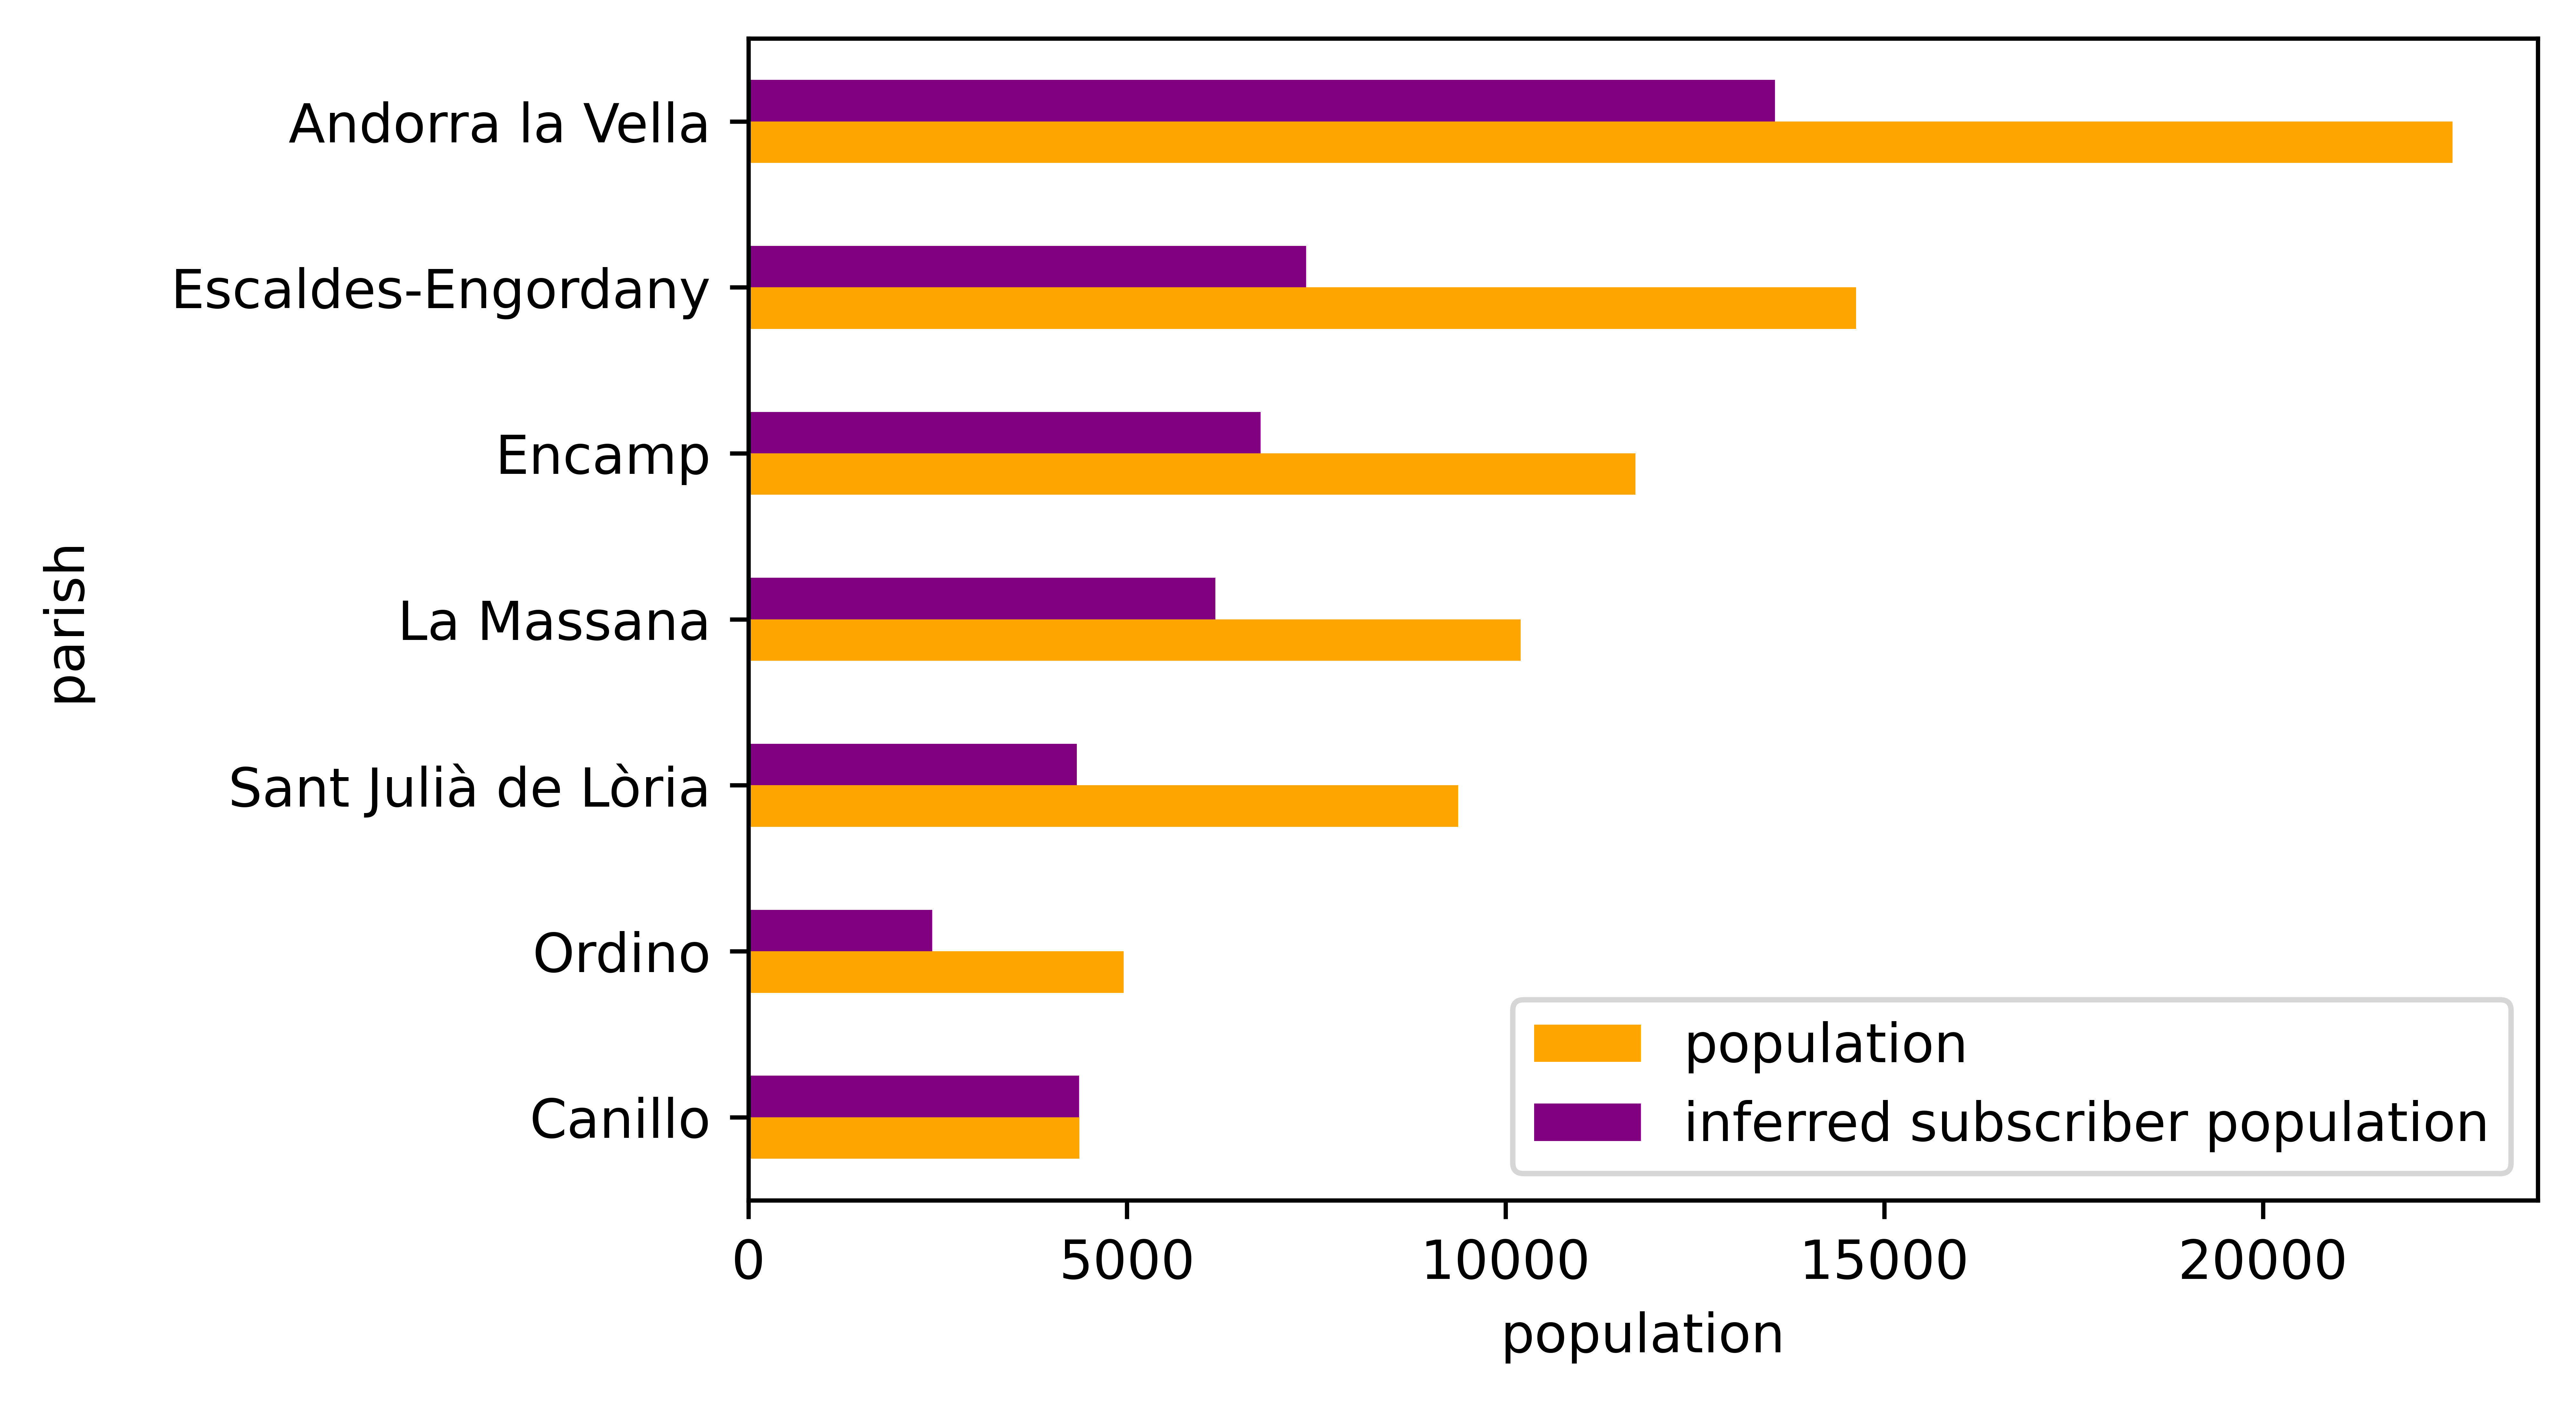

In [18]:
plt.rcParams["figure.dpi"] = 600
pop_stats_df.sort_values('population').plot.barh(color={
    'population':'orange',
    'inferred subscriber population':'purple'
})
plt.xlabel('population')
plt.ylabel('parish', labelpad=15)
plt.show()

## Parish departures and missed tests

### Serology data

In [19]:
SEROLOGY_DATA_FILEPATH = DATA_FILEPATH + 'serology_clean.csv'

In [20]:
# columns of interest

PARISH = 'parish'
DATA_TEST_1_DATE = 'data_test_1'
DATA_TEST_2_DATE = 'data_test_2'
IGM_1 = 'igm_1'
IGG_1 = 'igg_1'

POSITIVE_TEST_RESULT_VALUE = 'positiu' # positive test result  value in the original data

POSITIVE_TEST_1 = 'positive test 1'

In [21]:
# the PII is 'cens_hashed' -- ignore it / don't even need it
serology_df=pd.read_csv(SEROLOGY_DATA_FILEPATH)[
    [PARISH, DATA_TEST_1_DATE, DATA_TEST_2_DATE, IGM_1, IGG_1]]
serology_df.head()

/Users/aberke/projects/CSL_Andorra_COVID/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (9,10,14,20,24,32,33,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


parish   data_test_1    data_test_2    igm_1    igg_1
0  Escaldes Engordany  9/5/20 11:04  23/5/20 11:03  negatiu  negatiu
1  Escaldes Engordany  8/5/20 12:30  22/5/20 12:16  negatiu  negatiu
2    Andorra La Vella   6/5/20 8:29   14/5/20 9:38  negatiu  negatiu
3          La Massana   7/5/20 9:56   21/5/20 9:49  negatiu  negatiu
4  Escaldes Engordany   9/5/20 7:55   23/5/20 6:42  negatiu  negatiu

In [22]:
n_na_parish = len(serology_df[serology_df[PARISH].isna()])
print('%s people with null parish value. They will not be counted.' % n_na_parish)
parish_nulls  = serology_df[serology_df[PARISH].isna()]
print("A bunch of others have null rows too. They got into the database and didn't test. They will not be counted either.")
parish_nulls.head()

172 people with null parish value. They will not be counted.
A bunch of others have null rows too. They got into the database and didn't test. They will not be counted either.


parish data_test_1 data_test_2 igm_1 igg_1
411     NaN         NaN         NaN   NaN   NaN
2369    NaN         NaN         NaN   NaN   NaN
3851    NaN         NaN         NaN   NaN   NaN
5989    NaN         NaN         NaN   NaN   NaN
6800    NaN         NaN         NaN   NaN   NaN

### How does the rate at which people left parishes compare to rate at which people skipped the 2nd test?

In [90]:
N = 'N'
DID_TEST_1 = 'did test 1'
N_DID_TEST_1 = N + ' ' + DID_TEST_1
DID_TEST_1_AND_2  = 'did test 1 and 2'
N_DID_TEST_1_AND_2  = N +' '+DID_TEST_1_AND_2
P_DECLINE  = '(%) decline in participation'

serology_df[DID_TEST_1] = (serology_df[DATA_TEST_1_DATE].notnull())
serology_df[DID_TEST_1_AND_2] = (serology_df[DATA_TEST_1_DATE].notnull() \
                                 & serology_df[DATA_TEST_2_DATE].notnull())
serology_df[DID_TEST_1_NOT_2] = (serology_df[DATA_TEST_1_DATE].notnull() \
                                 & serology_df[DATA_TEST_2_DATE].isnull())
serology_df[[PARISH, DID_TEST_1, DID_TEST_1_AND_2]].head()

parish  did test 1  did test 1 and 2
0  Escaldes Engordany        True              True
1  Escaldes Engordany        True              True
2    Andorra La Vella        True              True
3          La Massana        True              True
4  Escaldes Engordany        True              True

Make a table:

```
parish, N did test 1, N did test 1 and 2, % decline in participation
```

In [108]:
parish_counts_df = serology_df[PARISH].value_counts().rename(N).to_frame().reset_index().rename(
    columns={'index':PARISH}).set_index(PARISH)
parish_counts_df[N_DID_TEST_1] = serology_df[serology_df[DID_TEST_1]][PARISH].value_counts()
parish_counts_df[N_DID_TEST_1_AND_2] = serology_df[serology_df[DID_TEST_1_AND_2]][PARISH].value_counts()
parish_counts_df[P_DECLINE] = 100*(parish_counts_df[N_DID_TEST_1] - parish_counts_df[N_DID_TEST_1_AND_2])/parish_counts_df[N_DID_TEST_1]
print('%s participants with parish and test 1 data' % parish_counts_df[N_DID_TEST_1].sum())
parish_counts_df.drop(N, axis=1).round(1).sort_index()

70496 participants with parish and test 1 data


N did test 1  N did test 1 and 2  (%) decline
parish                                                           
Andorra La Vella            4542                4262          6.2
Canillo                     4495                4017         10.6
Encamp                     10846               10273          5.3
Escaldes Engordany         28924               27688          4.3
La Massana                  8843                8451          4.4
Ordino                      4214                4049          3.9
Sant Julia                  8632                8295          3.9

### Using Mobility data

The serology tests were conducted  in May.

Two rounds of testing:
- First: May 4 - 14, 2020
- Second: May 18 - 28, 2020


For each parish, how many people who were present during the first round were also present during the second round?

How does this  change compare to the previous year?


Make a table about parish presence (for 2020 and 2019)
```
parish, N May start, N May end, portion decline
```

In [92]:
"""
Get the homes  parish data for May.

Check for user presence in May 4-14 vs May 18-28
"""

TEST_1 = 'test 1'
N_TEST_1 = 'N ' + TEST_1
TEST_2 = 'test 2'
N_TEST_2 = 'N ' + TEST_2

P_DECLINE  = '(%) decline'

In [93]:
def daterange(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield start_datetime + timedelta(n)

date_fmt = '%Y-%m-%d'

test1_2020_dates = [d for d in daterange(datetime.strptime('2020-05-04', date_fmt), 
                                   datetime.strptime('2020-05-14', date_fmt))]
test1_2019_dates = [d for d in daterange(datetime.strptime('2019-05-04', date_fmt), 
                                   datetime.strptime('2019-05-07', date_fmt))]

test2_2020_dates = [d for d in daterange(datetime.strptime('2020-05-18', date_fmt), 
                                   datetime.strptime('2020-05-28', date_fmt))]
test2_2019_dates = [d for d in daterange(datetime.strptime('2019-05-18', date_fmt), 
                                   datetime.strptime('2019-05-28', date_fmt))]

In [94]:
def get_imsis_presence_dict(imsis, dates):
    imsis_presence_dict  = {imsi:False for imsi in imsis}
    for i, d in enumerate(dates):
        date_str = d.strftime(date_fmt)
        print('%s/%s: processing %s' % (i+1, len(dates), date_str))
        stays_df = pd.read_csv(get_stays_filepath(d.year, d.month, d.day))
        for imsi in stays_df[IMSI].unique():
            imsis_presence_dict[imsi] = True
    
    return imsis_presence_dict

In [33]:
# make a dict from stays files for dates of interest
may2020_imsis = may_2020_homes_df[IMSI].values
test1_2020_imsis_presence_dict = get_imsis_presence_dict(may2020_imsis, test1_2020_dates)
test2_2020_imsis_presence_dict = get_imsis_presence_dict(may2020_imsis, test2_2020_dates)

1/11: processing 2020-05-04
2/11: processing 2020-05-05
3/11: processing 2020-05-06
4/11: processing 2020-05-07
5/11: processing 2020-05-08
6/11: processing 2020-05-09
7/11: processing 2020-05-10
8/11: processing 2020-05-11
9/11: processing 2020-05-12
10/11: processing 2020-05-13
11/11: processing 2020-05-14
1/11: processing 2020-05-18
2/11: processing 2020-05-19
3/11: processing 2020-05-20
4/11: processing 2020-05-21
5/11: processing 2020-05-22
6/11: processing 2020-05-23
7/11: processing 2020-05-24
8/11: processing 2020-05-25
9/11: processing 2020-05-26
10/11: processing 2020-05-27
11/11: processing 2020-05-28


In [34]:
may2019_imsis = may_2019_homes_df[IMSI].values
test1_2019_imsis_presence_dict = get_imsis_presence_dict(may2019_imsis, test1_2019_dates)
test2_2019_imsis_presence_dict = get_imsis_presence_dict(may2019_imsis, test2_2019_dates)

1/4: processing 2019-05-04
2/4: processing 2019-05-05
3/4: processing 2019-05-06
4/4: processing 2019-05-07
1/11: processing 2019-05-18
2/11: processing 2019-05-19
3/11: processing 2019-05-20
4/11: processing 2019-05-21
5/11: processing 2019-05-22
6/11: processing 2019-05-23
7/11: processing 2019-05-24
8/11: processing 2019-05-25
9/11: processing 2019-05-26
10/11: processing 2019-05-27
11/11: processing 2019-05-28


In [37]:
may_2020_homes_df[TEST_1] = may_2020_homes_df[IMSI].map(test1_2020_imsis_presence_dict)
may_2020_homes_df[TEST_2] = may_2020_homes_df[IMSI].map(test2_2020_imsis_presence_dict)

may_2019_homes_df[TEST_1] = may_2019_homes_df[IMSI].map(test1_2019_imsis_presence_dict)
may_2019_homes_df[TEST_2] = may_2019_homes_df[IMSI].map(test2_2019_imsis_presence_dict)

may_2020_homes_df.drop(IMSI, axis=1).head() # do not show IMSI

parish  days  nights  mcc  datafiles  Andorran SIM  test 1  \
0     Andorra la Vella    31      10  213         31          True    True   
1     Andorra la Vella     7       5  214         31         False   False   
2     Andorra la Vella     9       1  213         31          True    True   
3  Sant Julià de Lòria     2       2  208         31         False    True   
4     Andorra la Vella     3       2  214         31         False    True   

   test 2  
0    True  
1    True  
2    True  
3   False  
4    True

In [39]:
print('%s total users present in May 2020'%len(may_2020_homes_df))
print('%s users present during test 1 period, 2020'%len(may_2020_homes_df[may_2020_homes_df[TEST_1]]))

print('\n%s total users present in May 2019'%len(may_2019_homes_df))
print('%s users present during test 1 period, 2019'%len(may_2019_homes_df[may_2019_homes_df[TEST_1]]))

may_2020_homes_df[may_2020_homes_df[TEST_1]].drop(IMSI, axis=1).head()


54309 total users present in May 2020
52424 users present during test 1 period, 2020

114796 total users present in May 2019
72277 users present during test 1 period, 2019


parish  days  nights  mcc  datafiles  Andorran SIM  test 1  \
0     Andorra la Vella    31      10  213         31          True    True   
2     Andorra la Vella     9       1  213         31          True    True   
3  Sant Julià de Lòria     2       2  208         31         False    True   
4     Andorra la Vella     3       2  214         31         False    True   
5     Andorra la Vella    31      16  213         31          True    True   

   test 2  
0    True  
2    True  
3   False  
4    True  
5    True

In [78]:
# restrict the data to only users present in 1st week of May and count
def get_counts_df(df, condition_days=0, condition_nights=0):
    condition = (df[TEST_1]&(df[DAYS]>=condition_days)&(df[NIGHTS]>=condition_nights))
    counts_df = df[condition][[PARISH,TEST_1,TEST_2]].groupby(PARISH).sum()
    counts_df[P_DECLINE] = 100*(counts_df[TEST_1]-counts_df[TEST_2])/counts_df[TEST_1]
    return counts_df

In [109]:
may_2020_counts_df = get_counts_df(may_2020_homes_df)
may_2020_counts_df['2020 population'] = may_2020_counts_df.index.map(pop_stats_df['population'])
may_2019_counts_df = get_counts_df(may_2019_homes_df)
may_2020_counts_df.round(1).sort_index()

test 1  test 2  (%) decline  2020 population
parish                                                           
Andorra la Vella      15803   15415          2.5            22504
Canillo                5406    5121          5.3             4371
Encamp                 7613    7449          2.2            11716
Escaldes-Engordany     8336    8172          2.0            14626
La Massana             7389    7214          2.4            10199
Ordino                 2821    2758          2.2             4957
Sant Julià de Lòria    5056    4929          2.5             9374

In [120]:
may_2019_counts_df.sort_index().round(1)

test 1  test 2  (%) decline
parish                                          
Andorra la Vella      27531   23295         15.4
Canillo                5095    3936         22.7
Encamp                 8102    7397          8.7
Escaldes-Engordany     9089    6961         23.4
La Massana             9813    8365         14.8
Ordino                 3446    2964         14.0
Sant Julià de Lòria    9201    8197         10.9

To what extent does this differ if we restrict the data to users with at least D=7 days of data?
Or N=4 nights of  data?



In [122]:
# for robustness checks:
# restrict the counts to users with at least a certain amount of days/nights of data
may_2020_7days_counts_df = get_counts_df(may_2020_homes_df, condition_days=7)
may_2019_7days_counts_df = get_counts_df(may_2019_homes_df, condition_days=7)

may_2020_4nights_counts_df = get_counts_df(may_2020_homes_df, condition_nights=4)
may_2019_4nights_counts_df = get_counts_df(may_2019_homes_df, condition_nights=4)

may_2020_4nights_counts_df.sort_index()

test 1  test 2  (%) decline
parish                                          
Andorra la Vella      11093   10944     1.343189
Canillo                4170    4016     3.693046
Encamp                 6144    6058     1.399740
Escaldes-Engordany     6368    6306     0.973618
La Massana             5439    5362     1.415701
Ordino                 2176    2152     1.102941
Sant Julià de Lòria    3281    3239     1.280098

In [123]:
color_2019 = 'tab:orange'
color_2020 = 'tab:blue'

In [124]:
def plot_portion_decline(df2019, df2020, title=''):
    decline_df = pd.DataFrame({
        'population': pop_stats_df.sort_index()['population'],
        '2019': 100 * df2019.sort_index()[P_DECLINE],
        '2020': 100 * df2020.sort_index()[P_DECLINE],
    })
    plt.rcParams["figure.dpi"] = 600
    ax = decline_df.sort_values('population')[
        ['2019', '2020']
    ].plot.barh(color={'2019':color_2019, '2020':color_2020})
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel('(%) Percent of week 1 subscribers who left by week 4')
    plt.ylabel('parish', labelpad=15)
    plt.show()
    return ax, decline_df

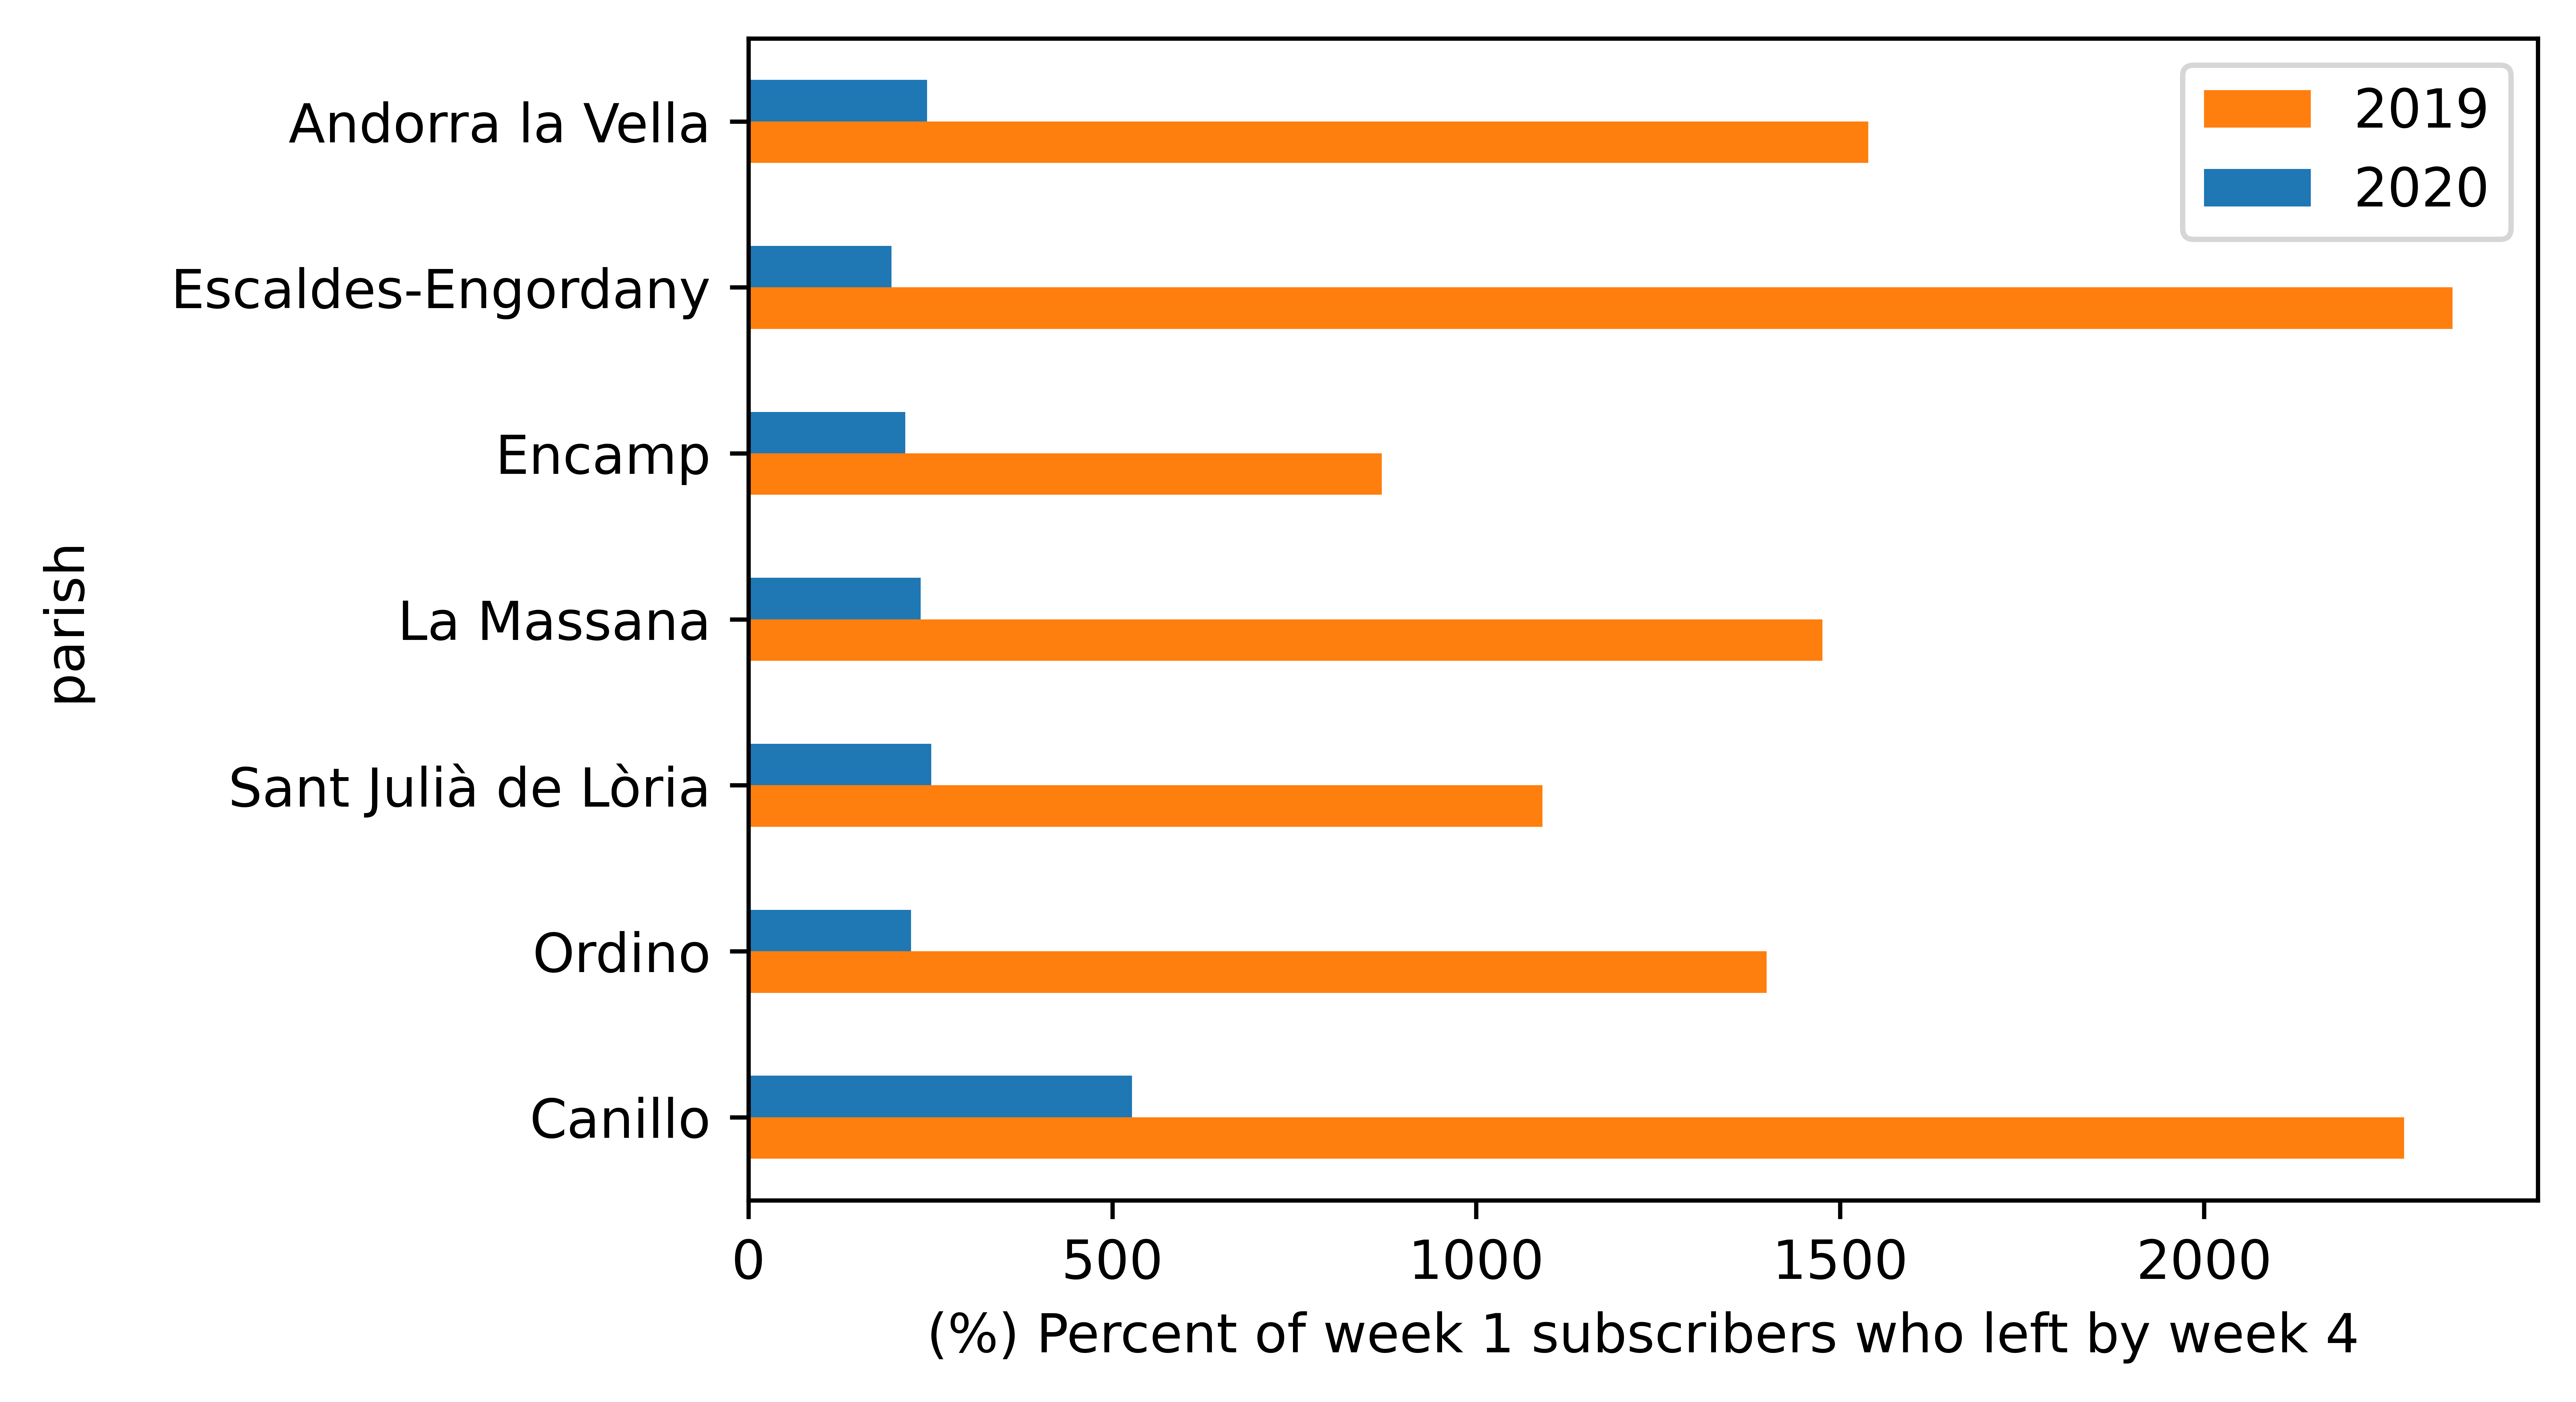

population         2019        2020
parish                                                  
Andorra la Vella          22504  1538.629182  245.523002
Canillo                    4371  2274.779195  527.192009
Encamp                    11716   870.155517  215.420990
Escaldes-Engordany        14626  2341.291671  196.737044
La Massana                10199  1475.593600  236.838544
Ordino                     4957  1398.723157  223.325062
Sant Julià de Lòria        9374  1091.185741  251.186709

In [125]:
title = 'Subscribers who left between 1st and 4th weeks of May'
ax, decline_df = plot_portion_decline(may_2019_counts_df, may_2020_counts_df)#, title)
decline_df

For robustness checks: See how this compares to when restricting to users with extra data.

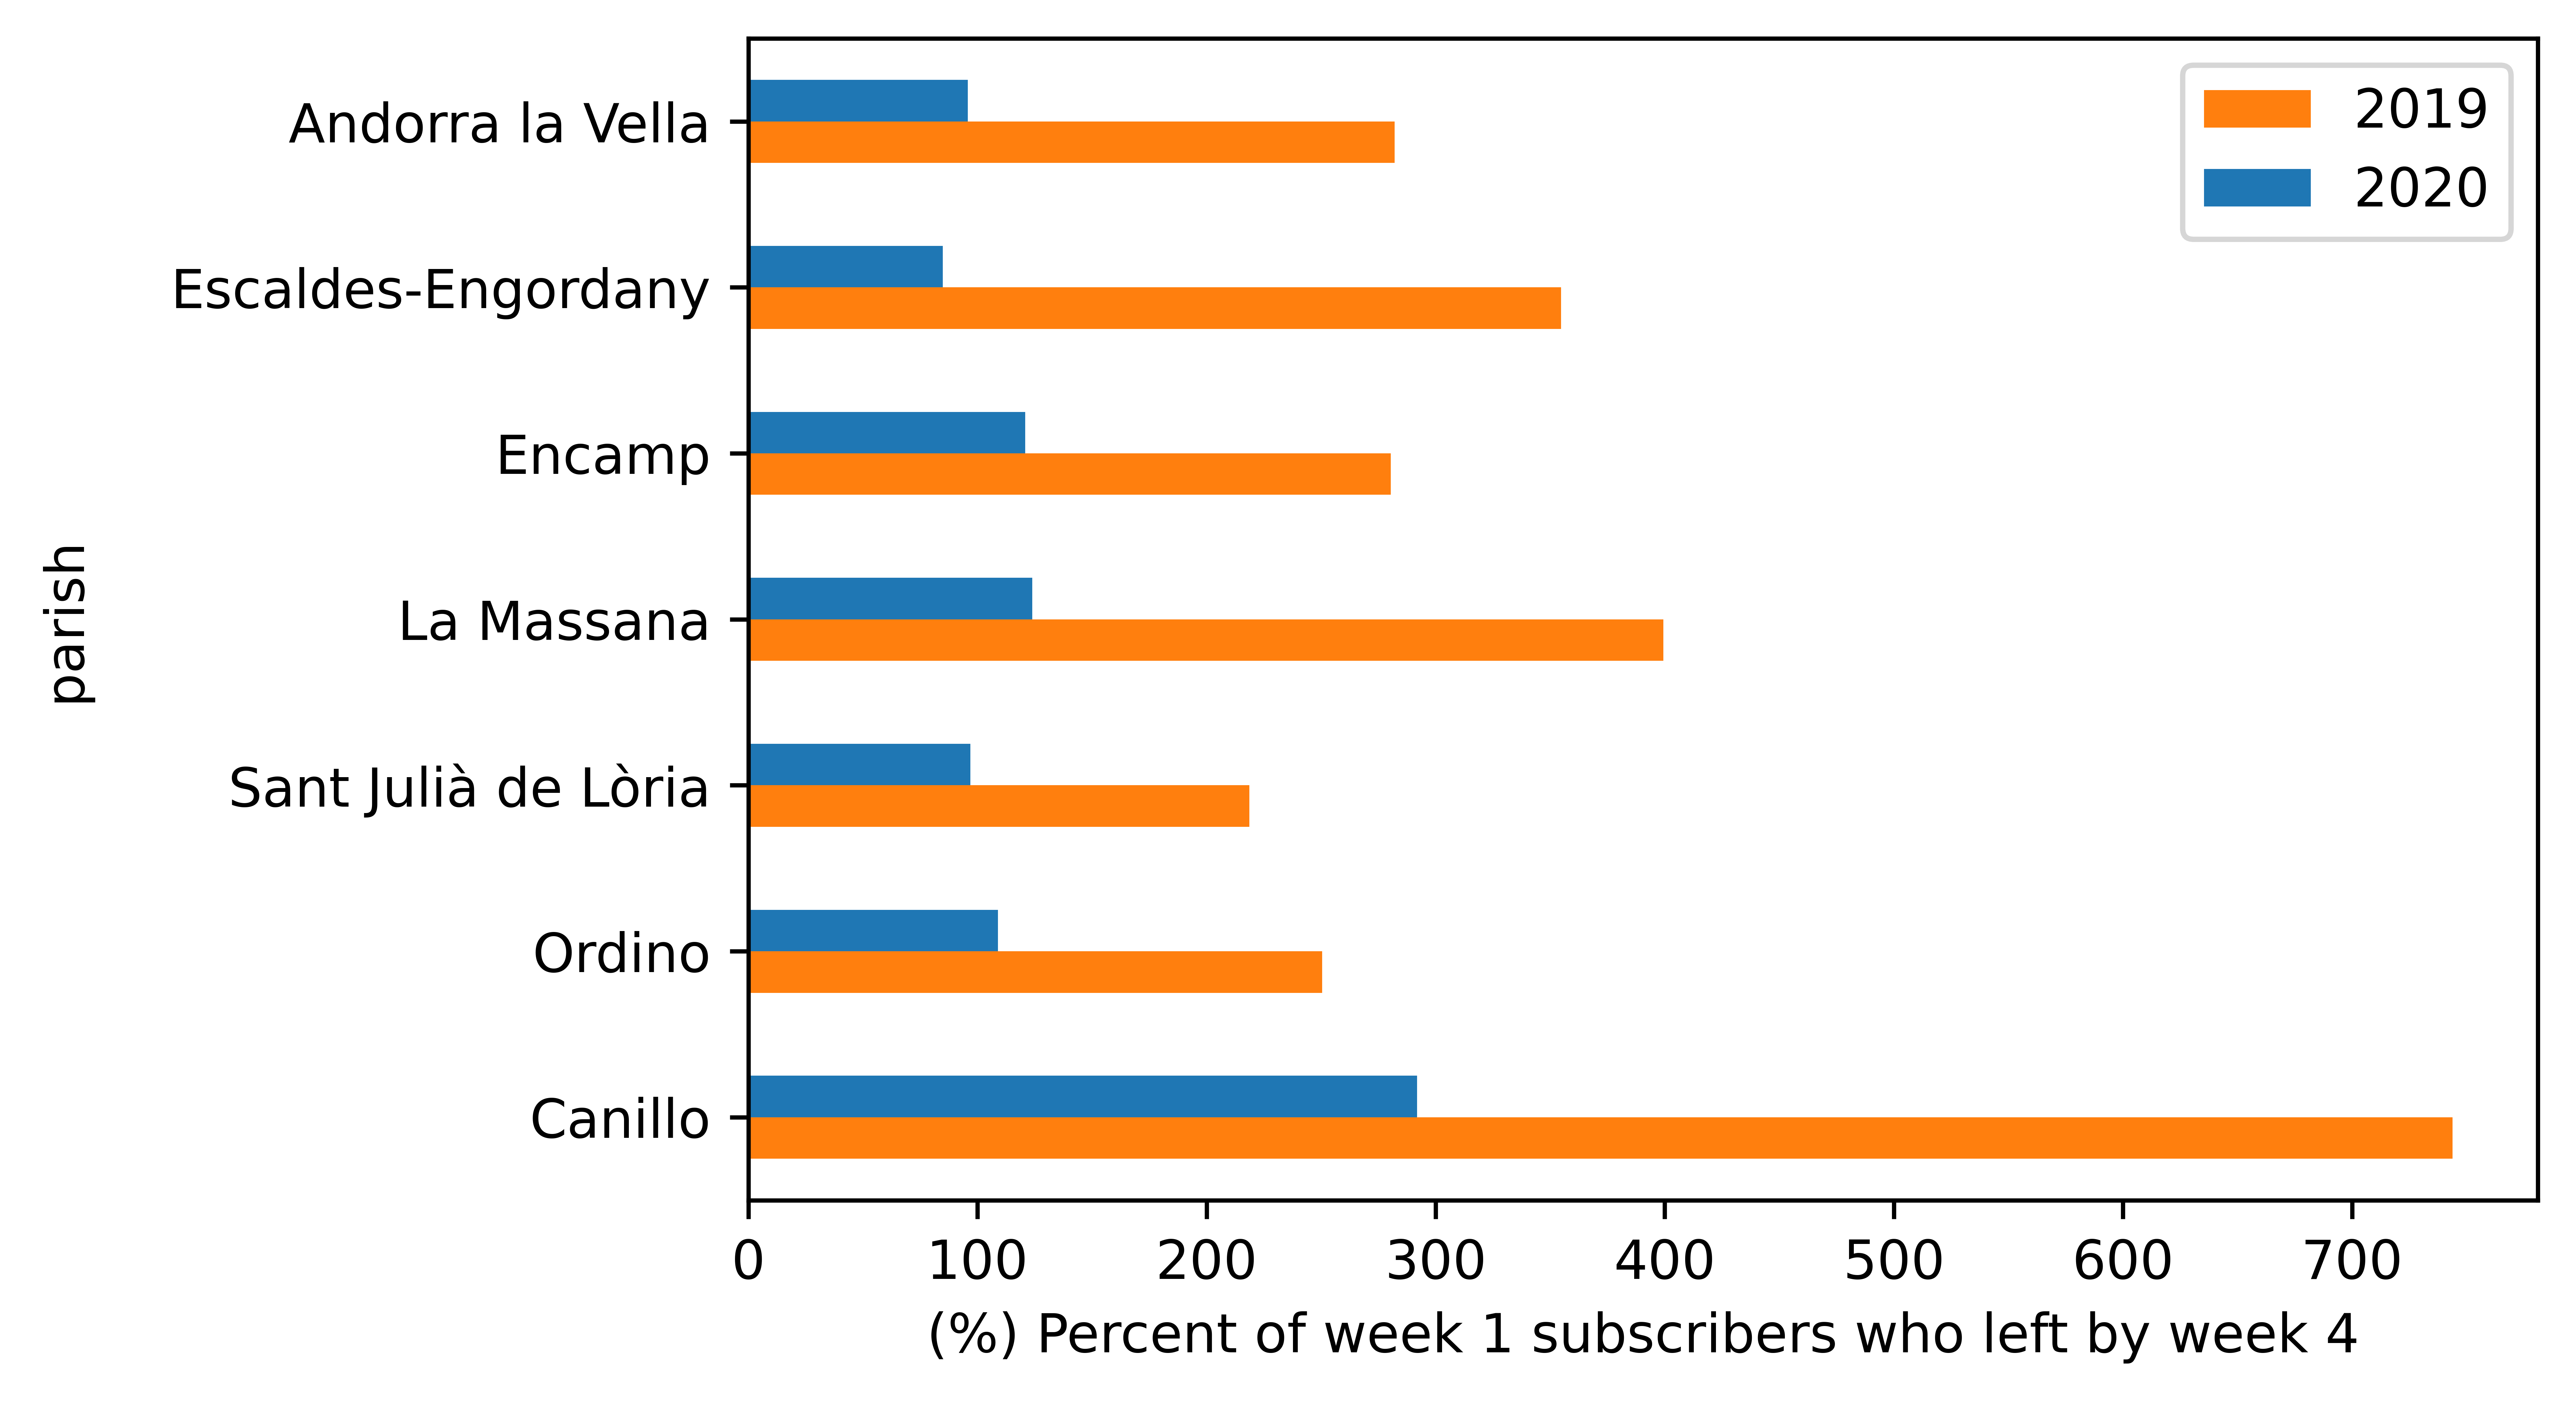

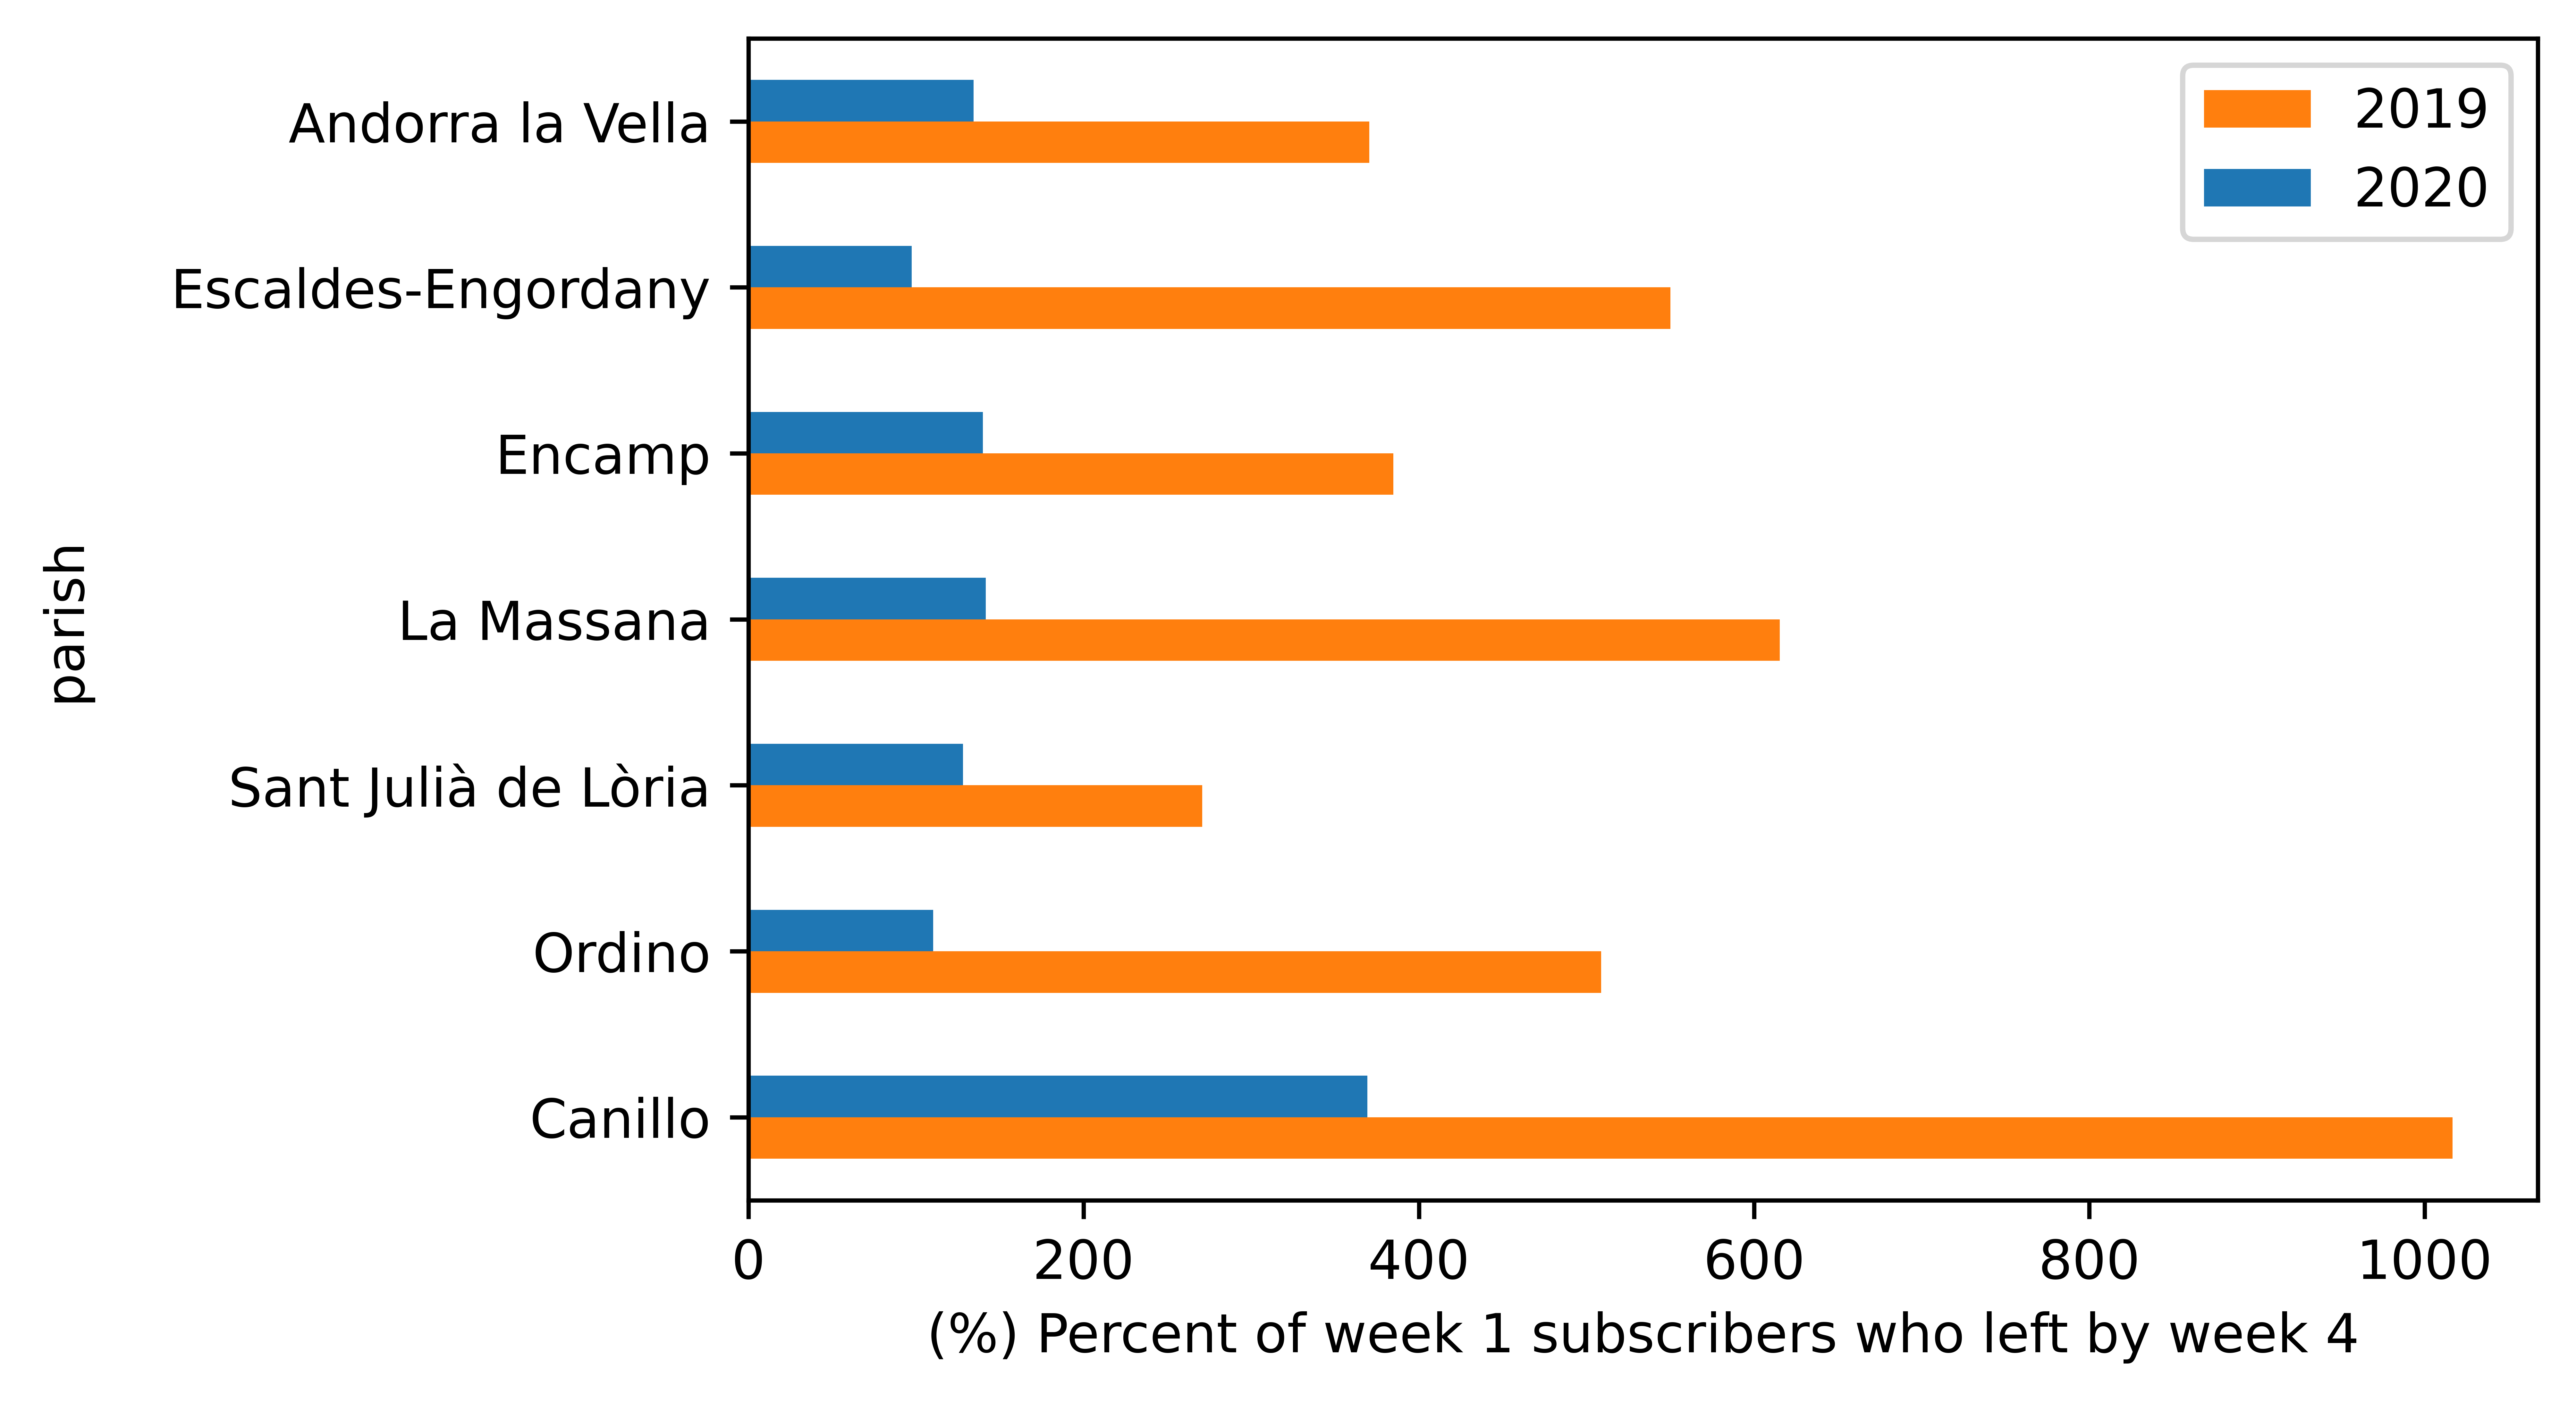

In [126]:
title_7days=title+'\n(restricted to users with at least 7 days of data)'
title_4nights=title+'\n(restricted to users with at least 4 nights of data)'
ax, decline_7days_df = plot_portion_decline(
    may_2019_7days_counts_df, 
    may_2020_7days_counts_df,
    #title_7days
)

ax, decline_4nights_df = plot_portion_decline(
    may_2019_4nights_counts_df,
    may_2020_4nights_counts_df,
    #title_4nights
)

In [128]:
# correlation between decline in subscribers vs no-shows to tests: 2020
(r, p_val) = pearsonr(
    decline_df['2020'].sort_index(), 
    parish_counts_df[P_DECLINE].sort_index()
)
print('Pearson correlation between the portion of May 2020 mobile subscribers '\
      'present during survey 1 period who left before survey 2 period '\
      'vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Pearson correlation between the portion of May 2020 mobile subscribers present during survey 1 period who left before survey 2 period vs portion of people who did test 1 but not test 2
r=0.9370 (p=0.0019)


Compare to decline in subscribers present in same period of *2019*

In [129]:
# correlation between decline in subscribers vs no-shows to tests: 2020
(r, p_val) = pearsonr(
    decline_df['2019'].sort_index(), 
    parish_counts_df[P_DECLINE].sort_index()
)
print('Pearson correlation between the portion of May 2019 mobile subscribers '\
      'present during survey 1 period who left before survey 2 period '\
      'vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Pearson correlation between the portion of May 2019 mobile subscribers present during survey 1 period who left before survey 2 period vs portion of people who did test 1 but not test 2
r=0.4928 (p=0.2612)


If the decline in subscribers was unrelated to people not showing up for their second test, then we would expect these values to be similar.

Robustness check: check correlation for subscriber data restricted to subscribers with a least 
- 7 days of data
- 4 nights of data

In [130]:
# Robustness check: Make the same comparisons for subscriber data restricted to 
# subscribers with a least 7 days of data
print('Restricting data to subscribers with at least 7 days of data:')
(r, p_val) = pearsonr(
    decline_7days_df['2020'].sort_index(), 
    parish_counts_df[P_DECLINE].sort_index()
)
print('Pearson correlation between the portion of May 2020 mobile subscribers '\
      'present during survey 1 period who left before survey 2 period '\
      'vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Restricting data to subscribers with at least 7 days of data:
Pearson correlation between the portion of May 2020 mobile subscribers present during survey 1 period who left before survey 2 period vs portion of people who did test 1 but not test 2
r=0.9252 (p=0.0028)


In [131]:
# Robustness check: Make the same comparisons for subscriber data restricted to 
# subscribers with a least 4 nights of data
print('Restricting data to subscribers with at least 4 nights of data:')
(r, p_val) = pearsonr(
    decline_4nights_df['2020'].sort_index(), 
    parish_counts_df[P_DECLINE].sort_index()
)
print('Pearson correlation between the portion of May 2020 mobile subscribers '\
      'present during survey 1 period who left before survey 2 period '\
      'vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Restricting data to subscribers with at least 4 nights of data:
Pearson correlation between the portion of May 2020 mobile subscribers present during survey 1 period who left before survey 2 period vs portion of people who did test 1 but not test 2
r=0.9554 (p=0.0008)


#### Plot it

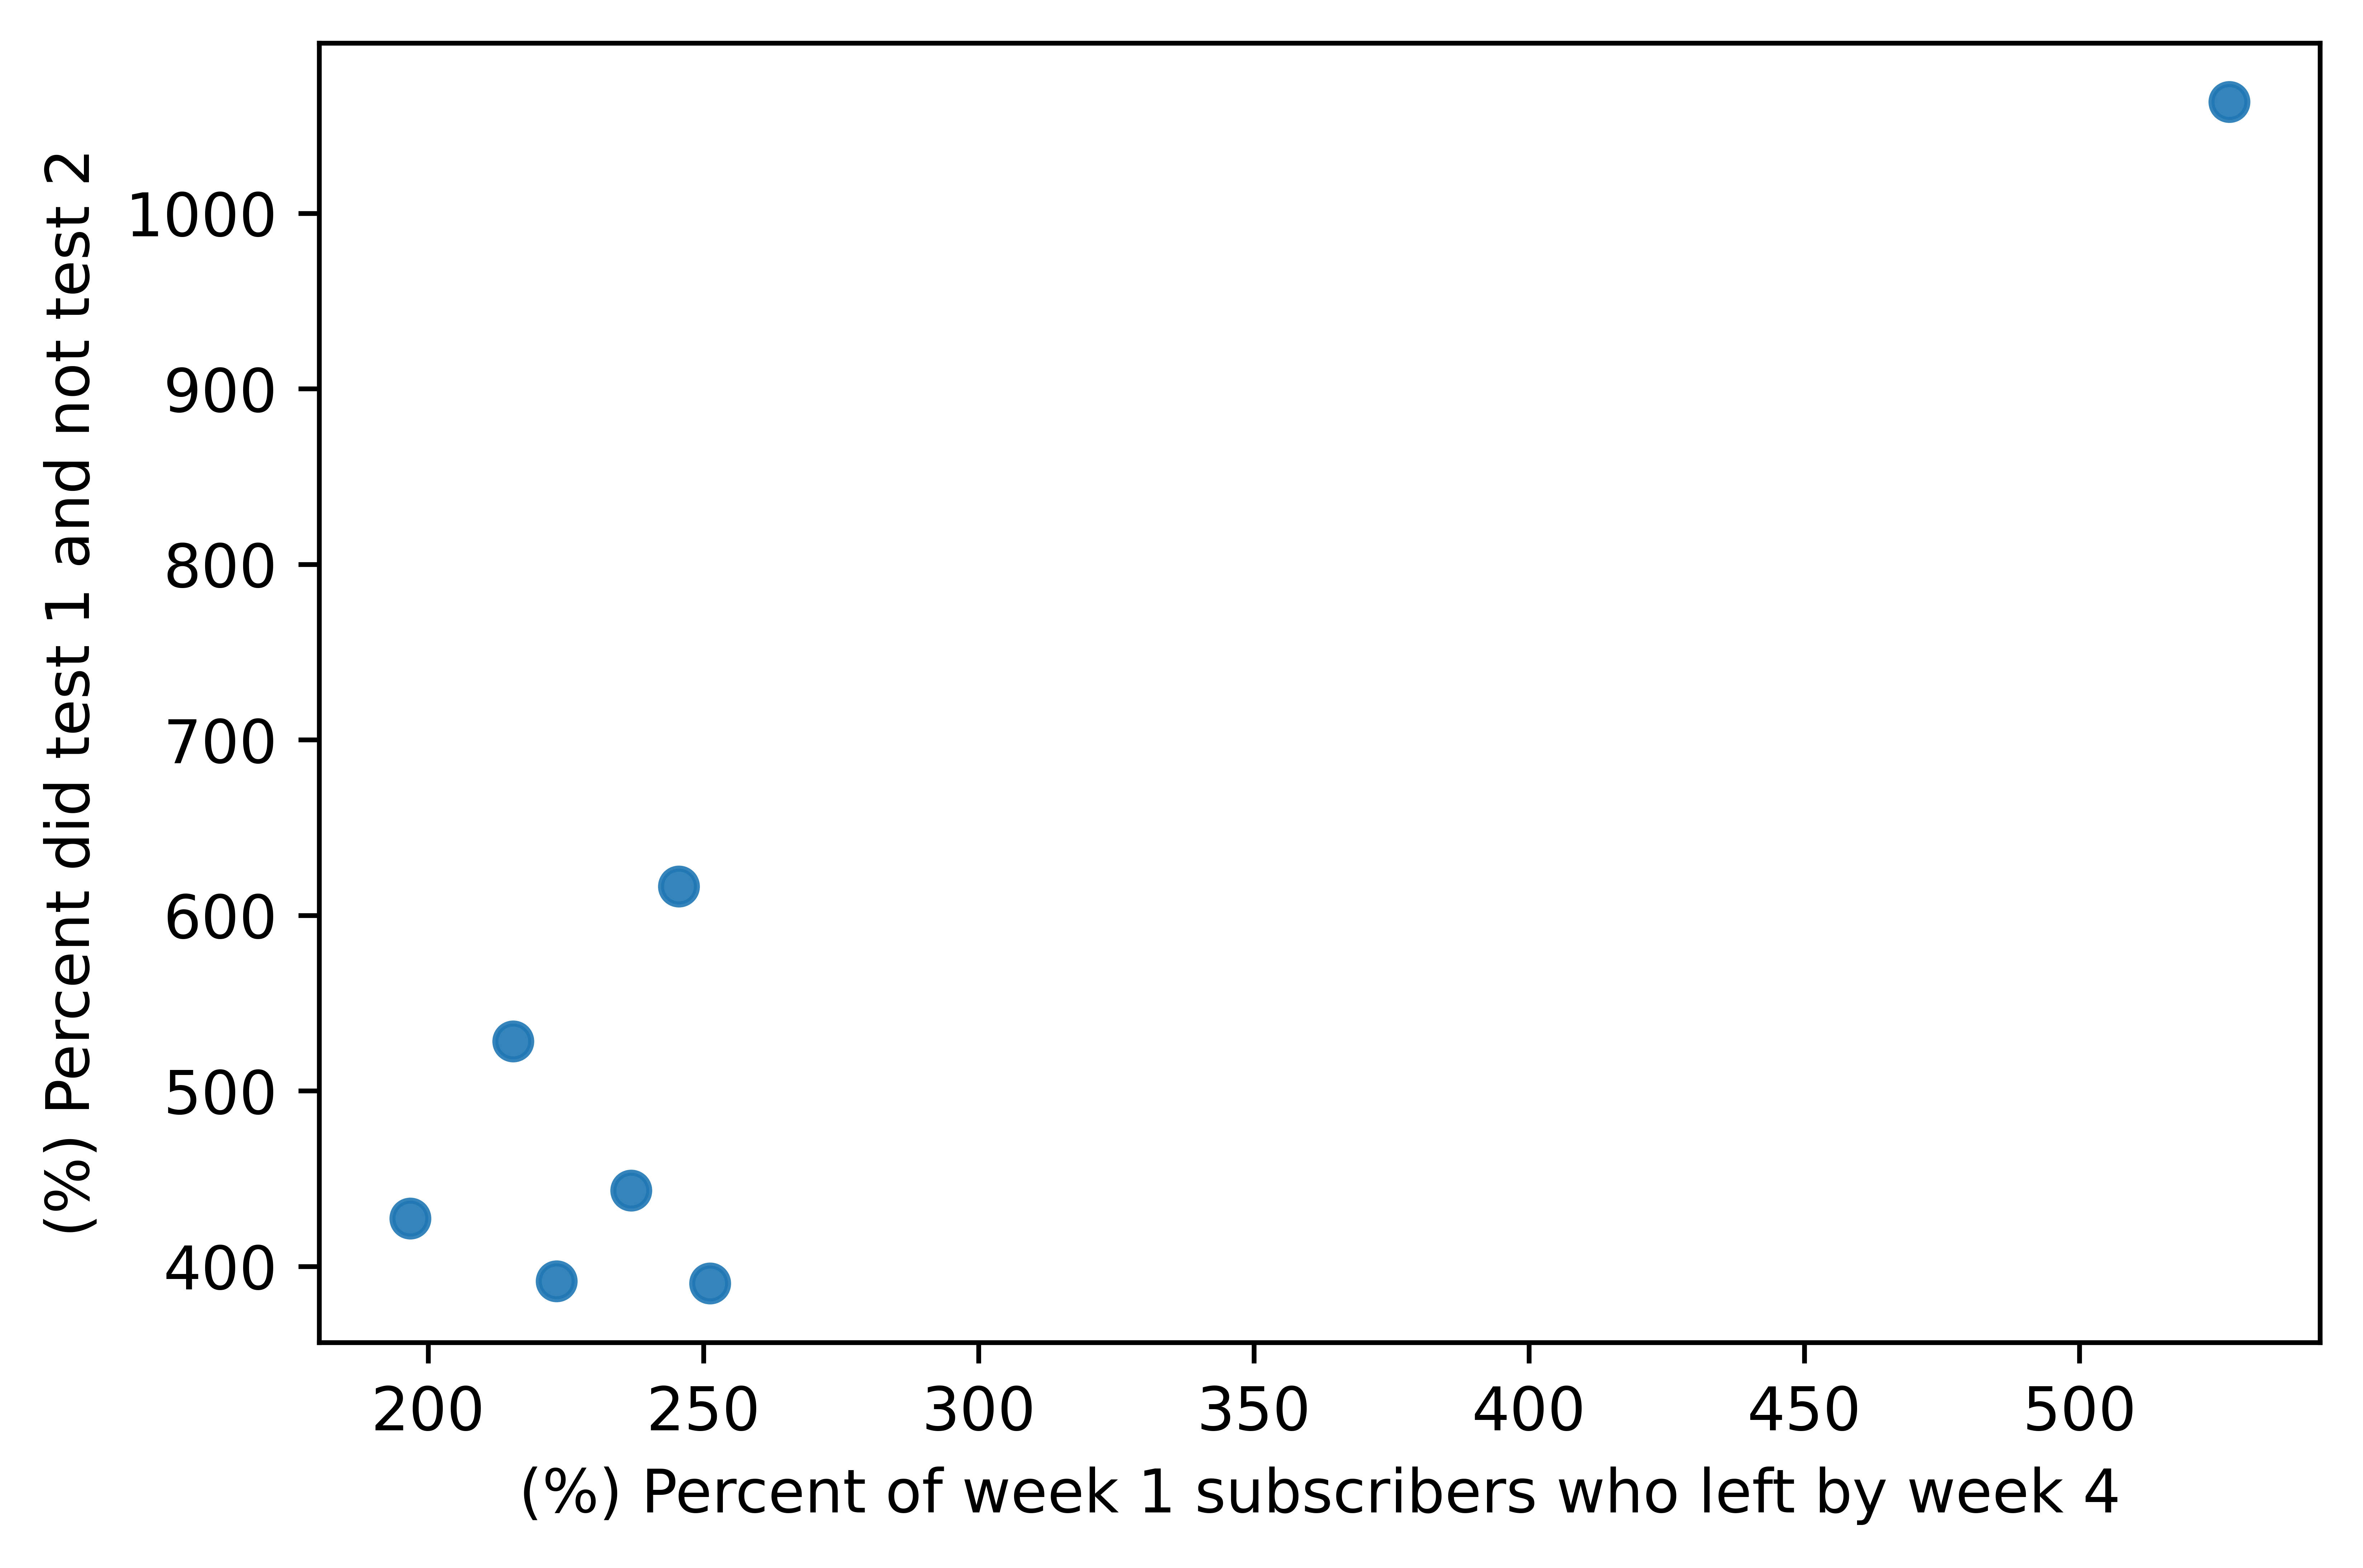

In [133]:
fig, ax = plt.subplots(dpi=600)
x_2020 = decline_df['2020'].sort_index()
y_2020 = 100* parish_counts_df[P_DECLINE].sort_index()
for i, (x,y) in enumerate(zip(x_2020, y_2020)):
    ax.scatter(x, y, color=color_2020, alpha=0.9, label='2020' if i == 0 else '')
ax.set_xlabel('(%) Percent of week 1 subscribers who left by week 4')
ax.set_ylabel('(%) Percent did test 1 and not test 2')
title = 'Change in May population and test participation'
# _ = ax.set_title(title)

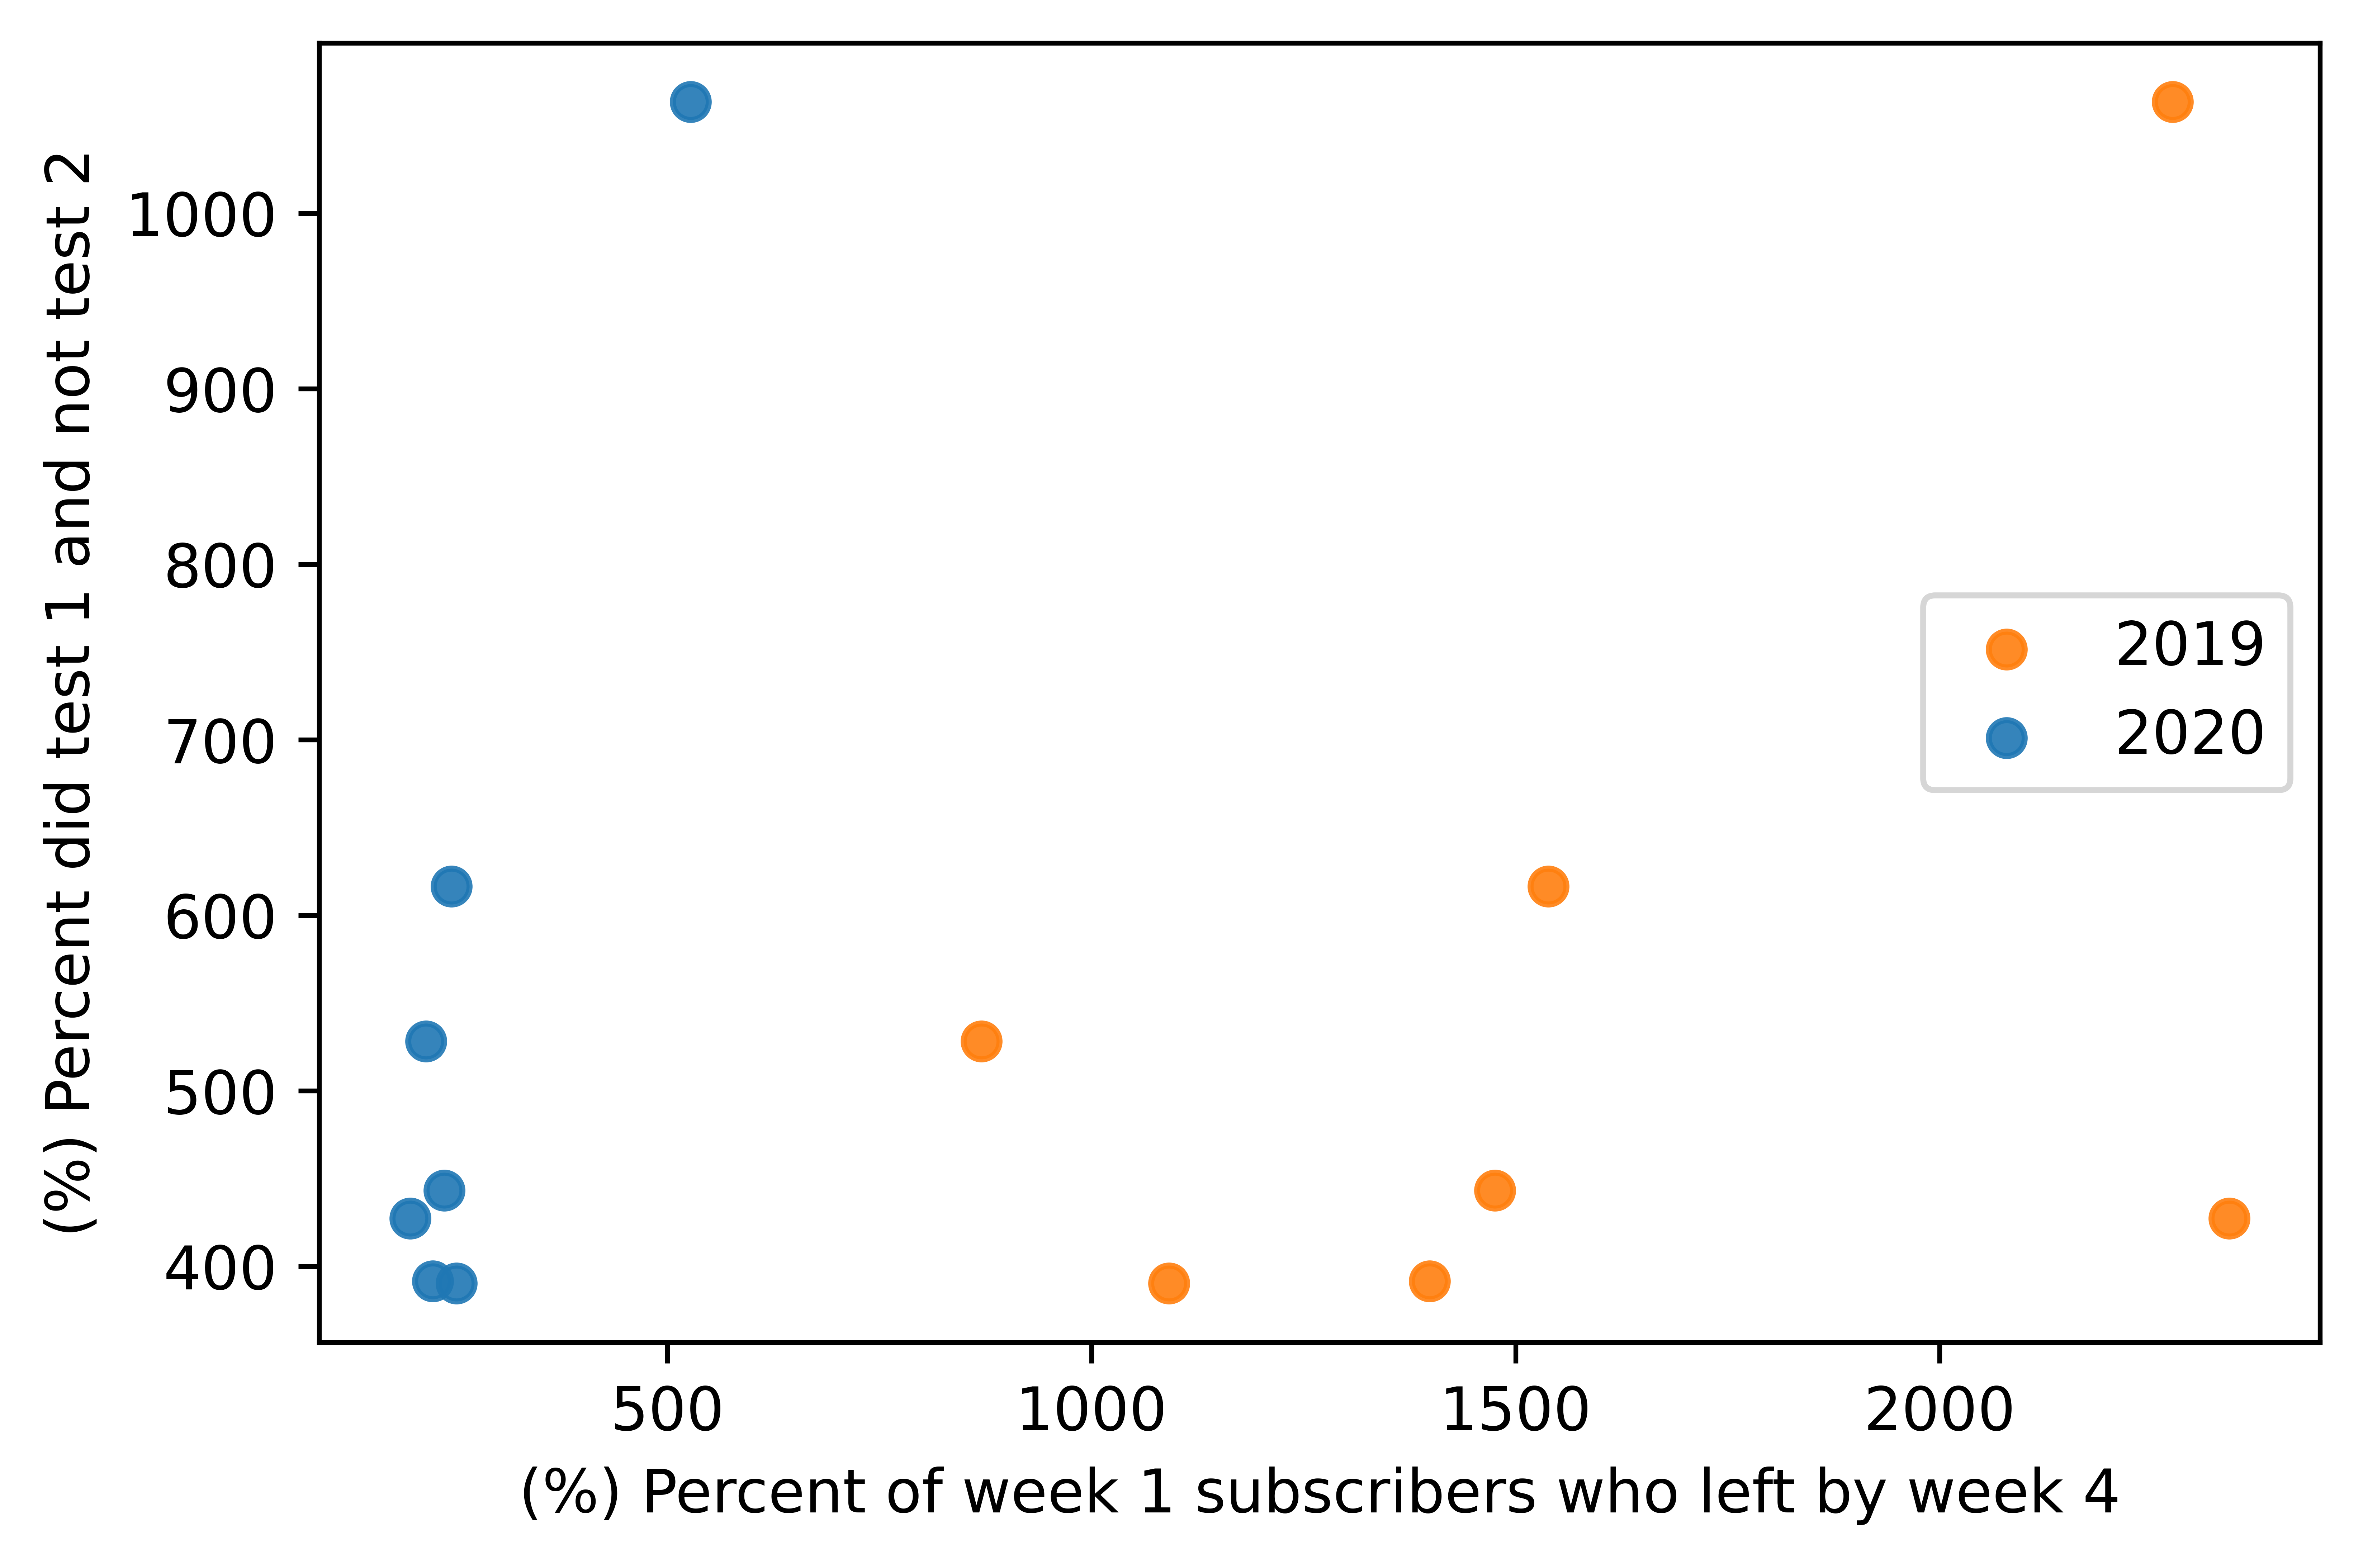

In [135]:
fig, ax = plt.subplots(dpi=600)
for i, (x,y) in enumerate(zip(decline_df['2019'].sort_index(), 100*parish_counts_df[P_DECLINE].sort_index())):
    ax.scatter(x, y, color=color_2019, alpha=0.9, label='2019' if i == 0 else '')
x_2020 = decline_df['2020'].sort_index()
y_2020 = 100* parish_counts_df[P_DECLINE].sort_index()
for i, (x,y) in enumerate(zip(x_2020, y_2020)):
    ax.scatter(x, y, color=color_2020, alpha=0.9, label='2020' if i == 0 else '')
ax.set_xlabel('(%) Percent of week 1 subscribers who left by week 4')
ax.set_ylabel('(%) Percent did test 1 and not test 2')
title = 'Change in May population and test participation'
# ax.set_title(title)
_ = ax.legend()

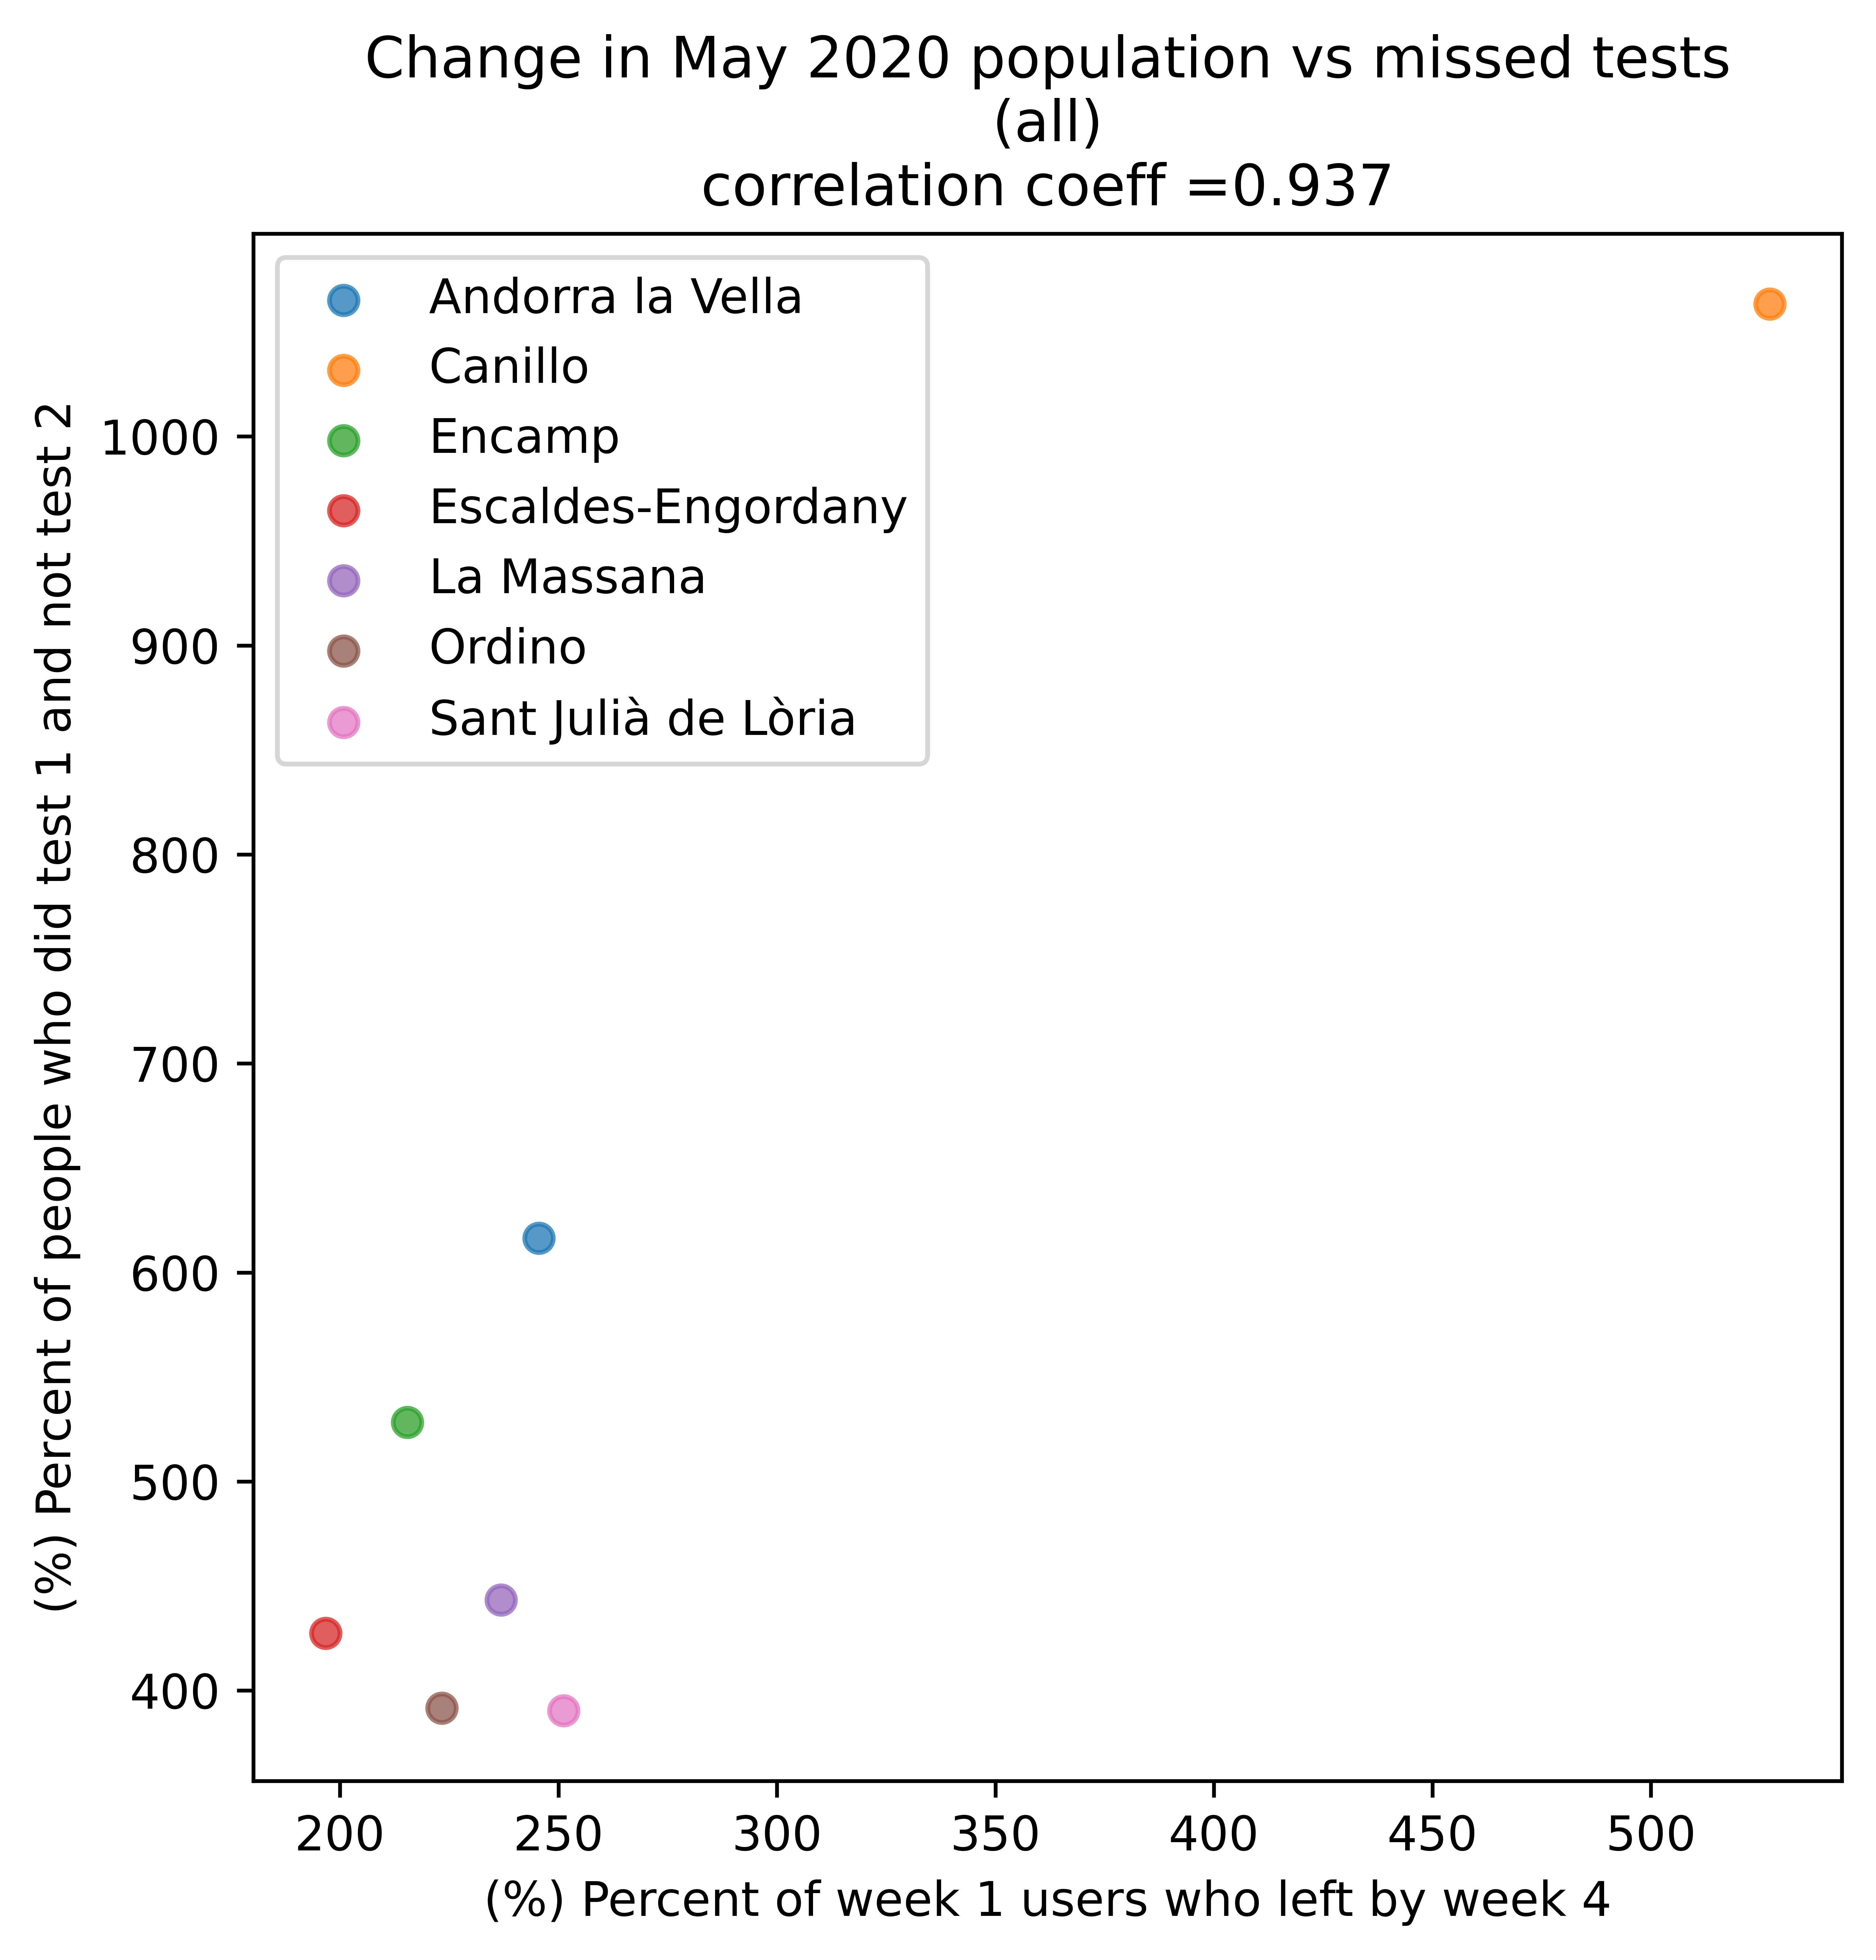

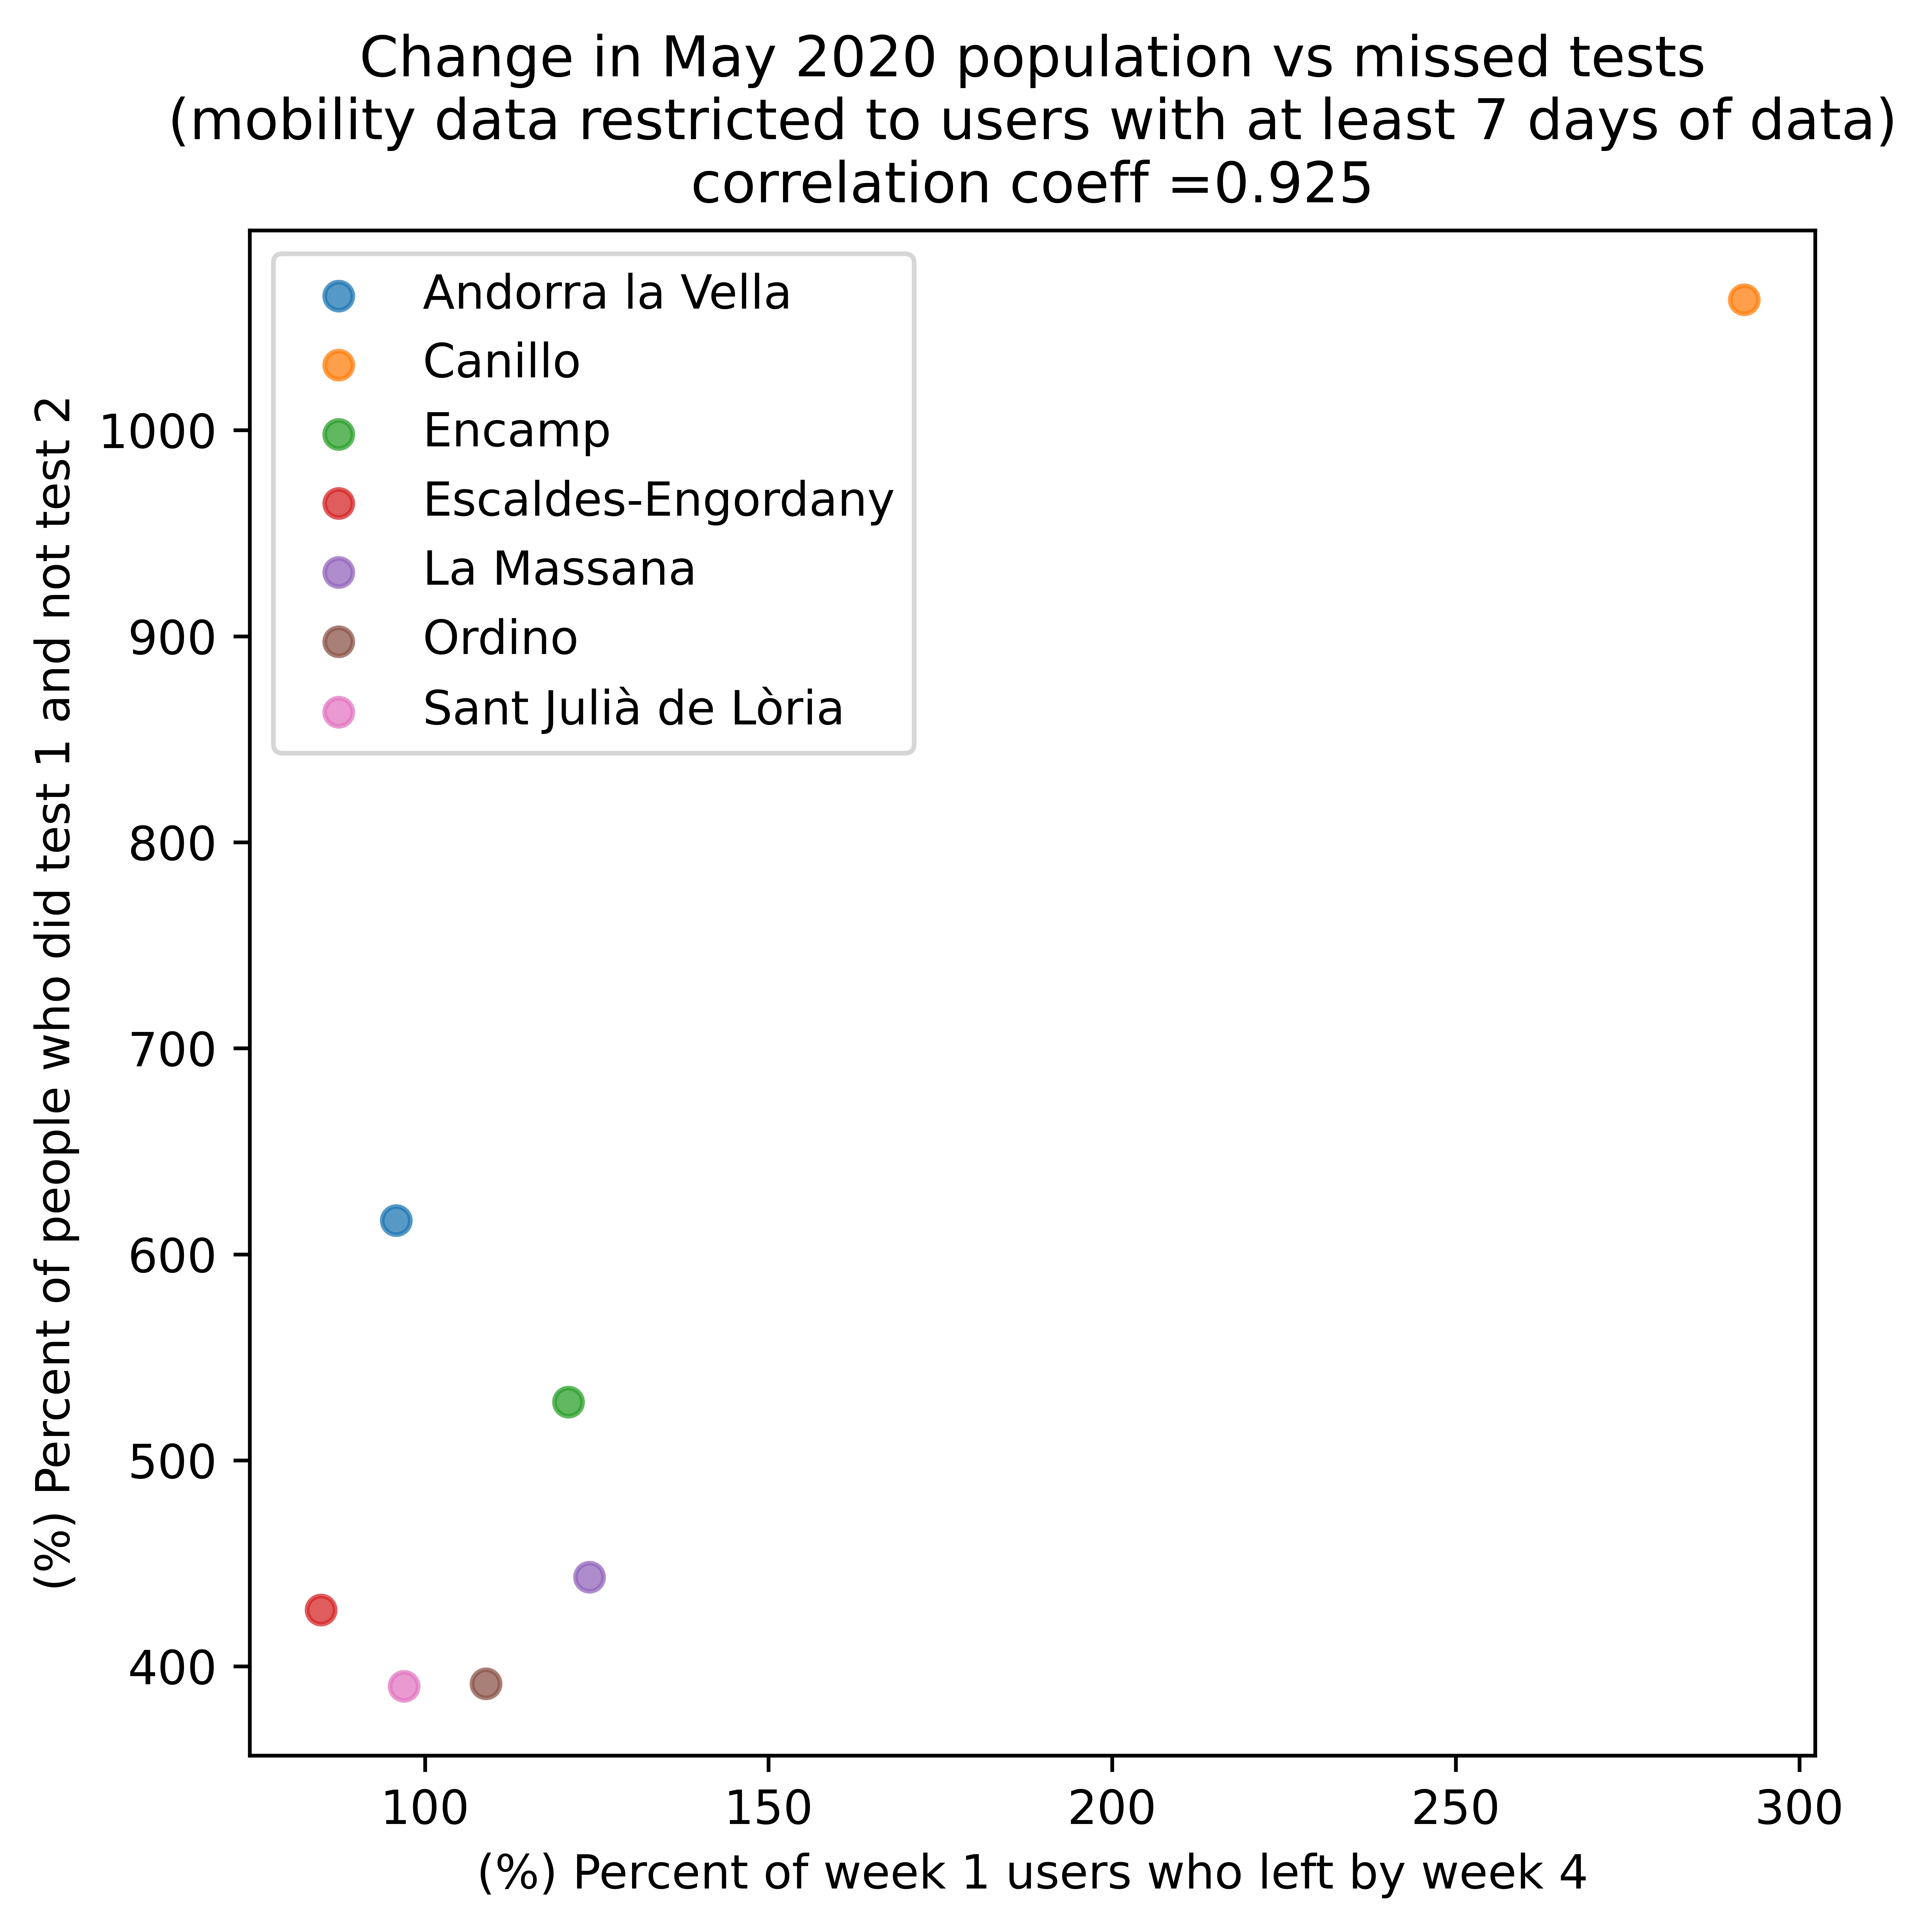

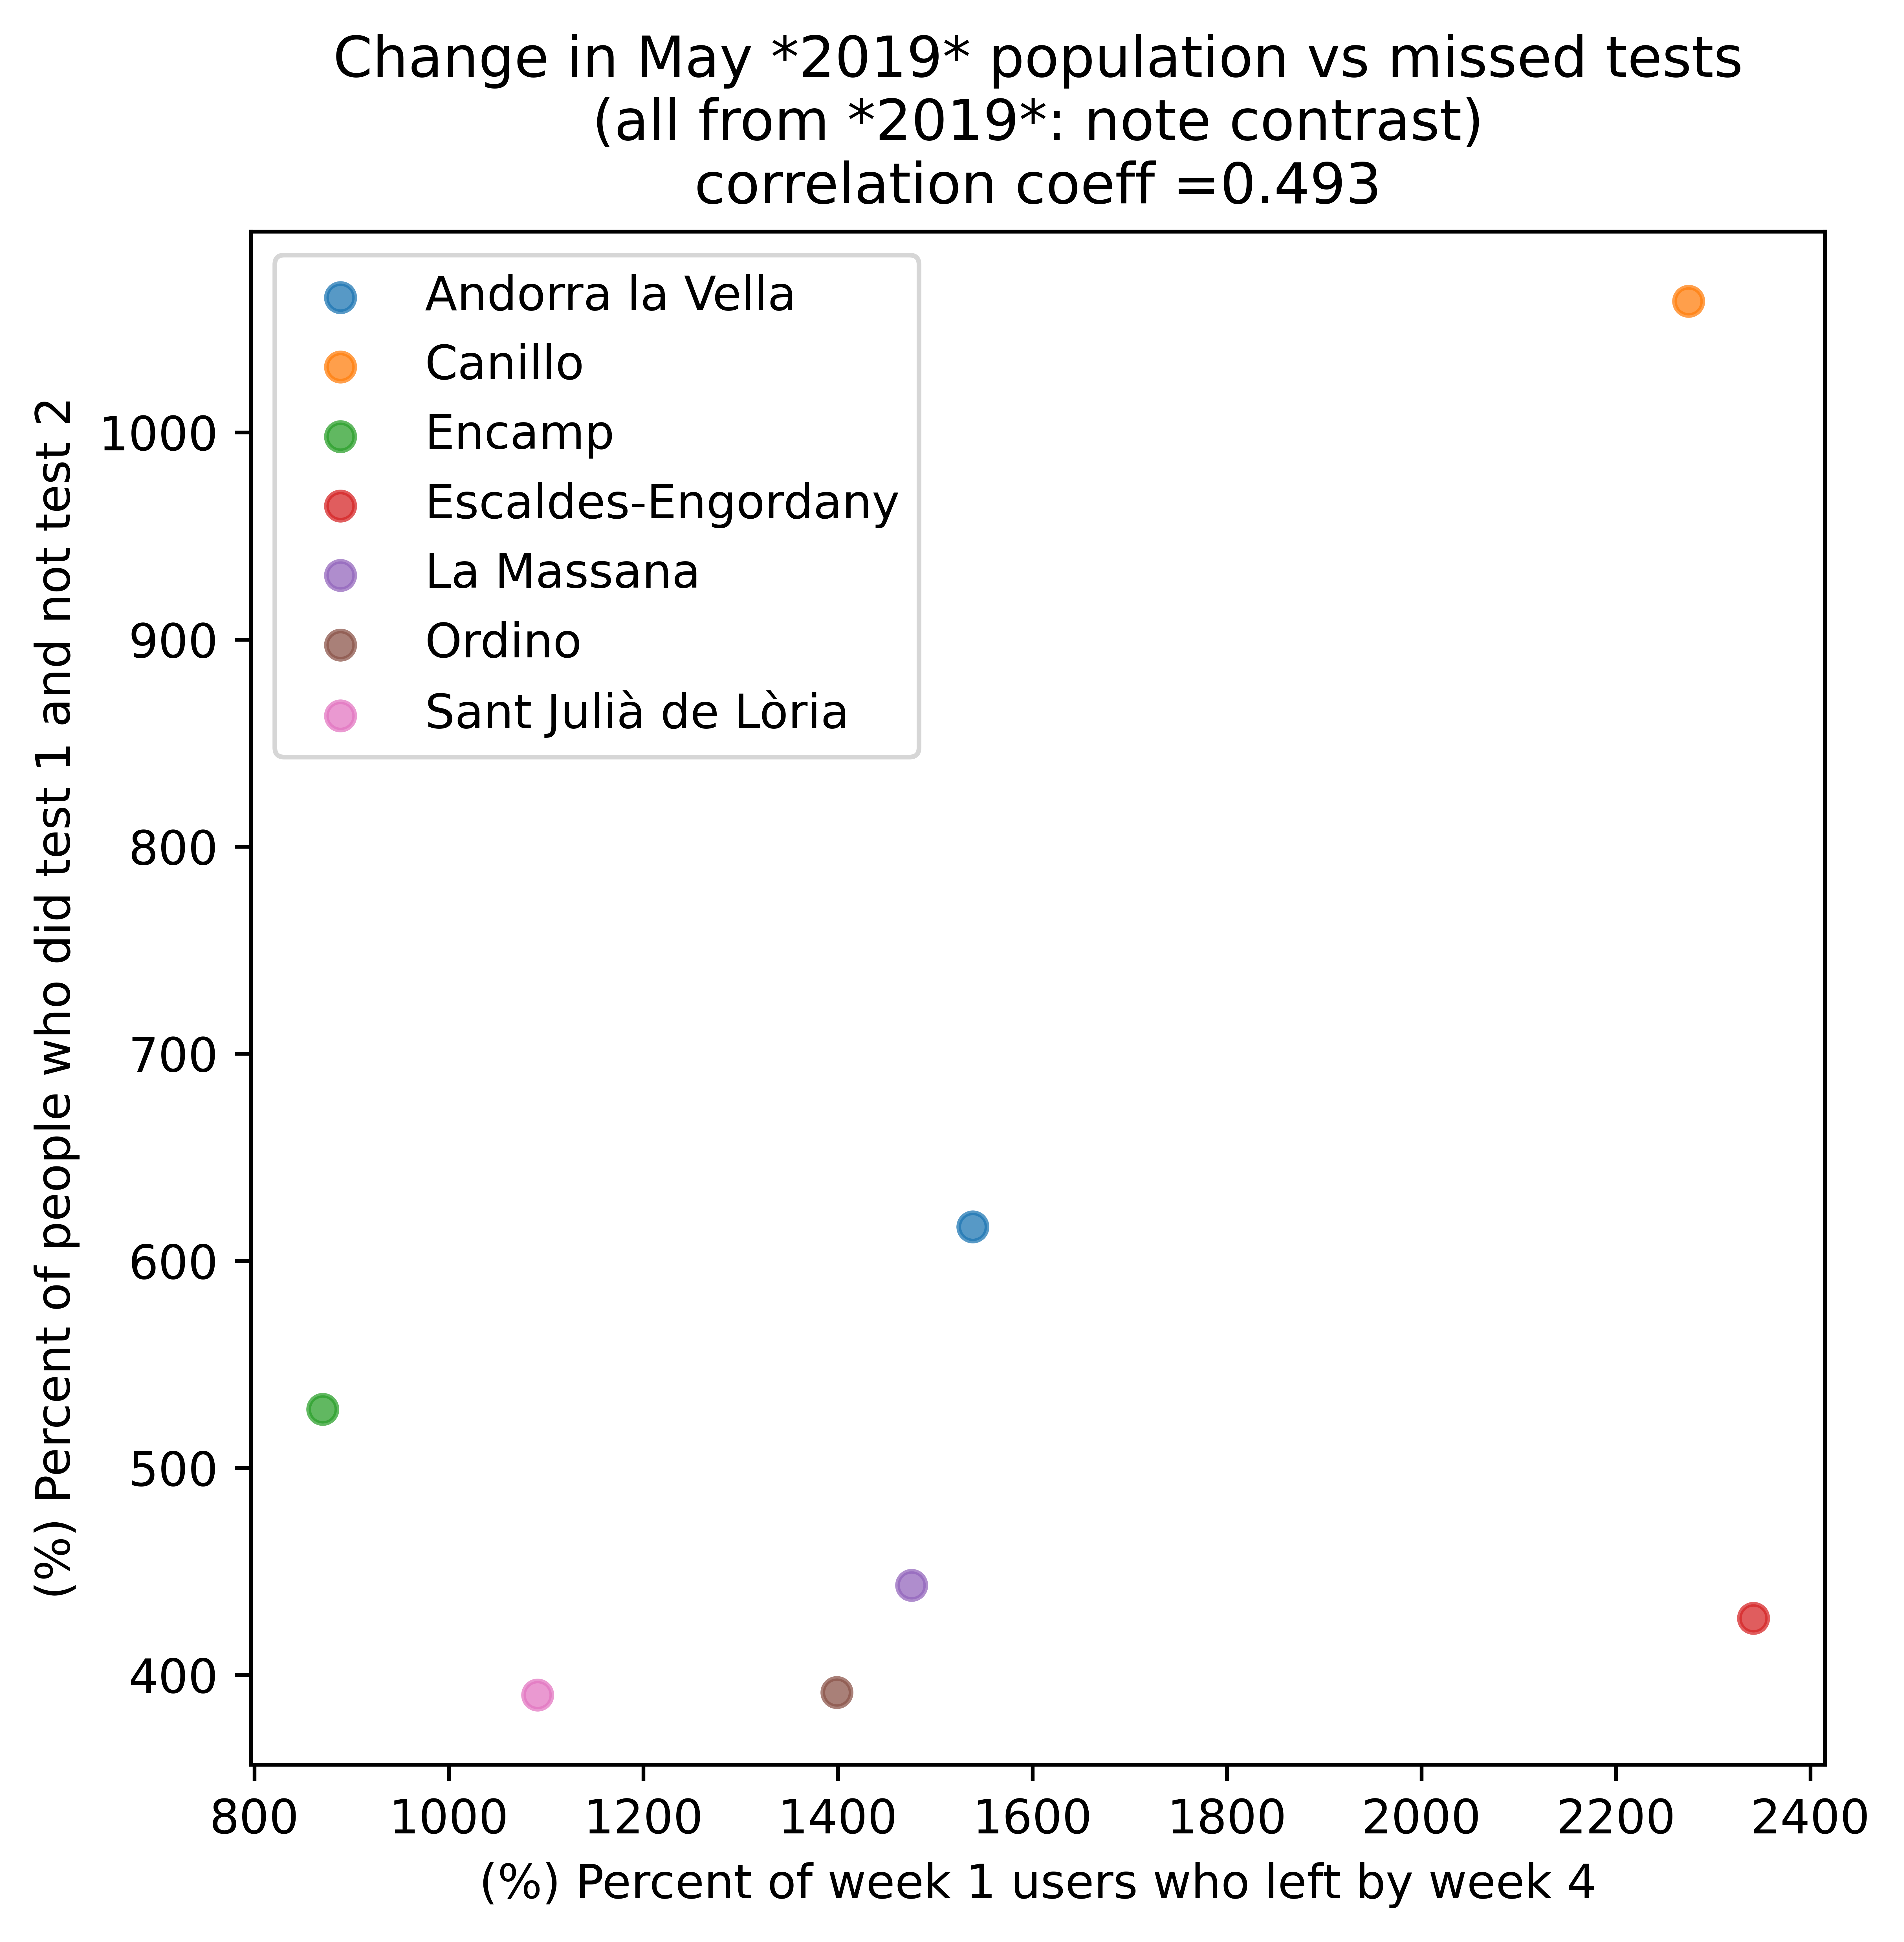

In [137]:
def plot_departures_vs_noshows(presence, tests, title):
    x=presence.sort_index()*100
    y=tests.sort_index()*100
    corr = np.corrcoef(x,y)[0,1].round(3)
    index=x.index
    fig, ax = plt.subplots(figsize=(6,6))
    for i, (x,y) in enumerate(zip(x,y)):
        ax.scatter(x, y,label=index.values[i],alpha=0.75)
    ax.legend()
    ax.set_title(title+'\ncorrelation coeff =%s'%corr)
    ax.set_xlabel('(%) Percent of week 1 users who left by week 4')
    ax.set_ylabel('(%) Percent of people who did test 1 and not test 2')
    plt.show()
    return ax

plot_departures_vs_noshows(may_2020_counts_df[P_DECLINE],
                           parish_counts_df[P_DECLINE],
                          'Change in May 2020 population vs missed tests\n(all)')
    
plot_departures_vs_noshows(may_2020_7days_counts_df[P_DECLINE],
                           parish_counts_df[P_DECLINE],
                          'Change in May 2020 population vs missed tests\n(mobility data restricted to users with at least 7 days of data)')
    
    
ax = plot_departures_vs_noshows(may_2019_counts_df[P_DECLINE],
                               parish_counts_df[P_DECLINE],
                              'Change in May *2019* population vs missed tests\n(all from *2019*: note contrast)')
    